In [2]:
from typing import Optional, Union, Dict, List
from uuid import uuid4
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

# Import data

In [3]:
from ucimlrepo import fetch_ucirepo 
import json

# fetch dataset 
steel_industry_energy_consumption = fetch_ucirepo(id=851) 
  
# data (as pandas dataframes) 
df = steel_industry_energy_consumption.data.original

# metadata 
print("Dataset Metadata:")
print(json.dumps(steel_industry_energy_consumption.metadata, indent=2))

Dataset Metadata:
{
  "uci_id": 851,
  "name": "Steel Industry Energy Consumption",
  "repository_url": "https://archive.ics.uci.edu/dataset/851/steel+industry+energy+consumption",
  "data_url": "https://archive.ics.uci.edu/static/public/851/data.csv",
  "abstract": "The data is collected from a smart small-scale steel industry in South Korea.",
  "area": "Physics and Chemistry",
  "tasks": [
    "Regression"
  ],
  "characteristics": [
    "Multivariate"
  ],
  "num_instances": 35040,
  "num_features": 9,
  "feature_types": [
    "Real",
    "Categorical"
  ],
  "demographics": [],
  "target_col": [
    "Load_Type"
  ],
  "index_col": null,
  "has_missing_values": "no",
  "missing_values_symbol": null,
  "year_of_dataset_creation": 2021,
  "last_updated": "Mon Aug 14 2023",
  "dataset_doi": "10.24432/C52G8C",
  "creators": [
    "Sathishkumar V E",
    "Changsun Shin",
    "Yongyun Cho"
  ],
  "intro_paper": {
    "ID": 262,
    "type": "NATIVE",
    "title": "Efficient energy consump

In [4]:
# variable information 
info = str(steel_industry_energy_consumption.variables[['name', 'role', 'type', 'units']]).split('\n')
desc = str(steel_industry_energy_consumption.variables[['description']]).split('\n')
full_info = ["\t".join([l_i, l_d[2:].strip()]) for l_i, l_d in zip(info, desc)]
print("\n".join(full_info))

                                    name     role         type  units	description
0                                   date    Other         Date   None	None
1                              Usage_kWh  Feature   Continuous    kWh	Industry Energy Consumption
2   Lagging_Current_Reactive.Power_kVarh  Feature   Continuous  kVarh	None
3   Leading_Current_Reactive_Power_kVarh  Feature   Continuous  kVarh	None
4                              CO2(tCO2)  Feature   Continuous    ppm	None
5           Lagging_Current_Power_Factor  Feature   Continuous      %	None
6           Leading_Current_Power_Factor  Feature   Continuous      %	None
7                                    NSM  Feature      Integer      s	None
8                             WeekStatus  Feature  Categorical   None	Weekend (0) or a Weekday(1)
9                            Day_of_week  Feature  Categorical   None	Sunday, Monday, ..., Saturday
10                             Load_Type   Target  Categorical   None	Light Load, Medium Load, Ma

In [5]:
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


# Check data

In [6]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

In [7]:
# Rename some columns to shorter form
df = df.rename({
    "Lagging_Current_Reactive.Power_kVarh": "Lagging_Reactive",
    "Leading_Current_Reactive_Power_kVarh": "Leading_Reactive",
    "Lagging_Current_Power_Factor": "Lagging_Factor",
    "Leading_Current_Power_Factor": "Leading_Factor"
}, axis=1)
df.head()

,date,Usage_kWh,Lagging_Reactive,Leading_Reactive,CO2(tCO2),Lagging_Factor,Leading_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


## Stats

In [8]:
def get_describe(X: pd.DataFrame) -> pd.DataFrame:
    X_stats = X.describe().T
    
    cols = X_stats.index
    if 'unique' not in X_stats:
        X_stats['unique'] = X[cols].nunique()
    X_stats["nan"] = X[cols].isna().sum()
    X_stats["nan %"] = X_stats["nan"] / X.shape[0]
    return X_stats

In [9]:
df_num = df.select_dtypes(include='number')
df_stats_num = get_describe(df_num)
df_stats_num

,count,mean,std,min,25%,50%,75%,max,unique,nan,nan %
Usage_kWh,35040.0,27.386892,33.444380,0.0,3.20,4.57,51.2375,157.18,3343,0,0.0
Lagging_Reactive,35040.0,13.035384,16.306000,0.0,2.30,5.00,22.6400,96.91,1954,0,0.0
Leading_Reactive,35040.0,3.870949,7.424463,0.0,0.00,0.00,2.0900,27.76,768,0,0.0
CO2(tCO2),35040.0,0.011524,0.016151,0.0,0.00,0.00,0.0200,0.07,8,0,0.0
Lagging_Factor,35040.0,80.578056,18.921322,0.0,63.32,87.96,99.0225,100.00,5079,0,0.0
Leading_Factor,35040.0,84.367870,30.456535,0.0,99.70,100.00,100.0000,100.00,3366,0,0.0
NSM,35040.0,42750.000000,24940.534317,0.0,21375.00,42750.00,64125.0000,85500.00,96,0,0.0


In [10]:
# Describe categorical fields
df_cat = df.select_dtypes(include='object')
df_stats_cat = get_describe(df_cat)
df_stats_cat

,count,unique,top,freq,nan,nan %
WeekStatus,35040,2,Weekday,25056,0,0.0
Day_of_week,35040,7,Monday,5088,0,0.0
Load_Type,35040,3,Light_Load,18072,0,0.0


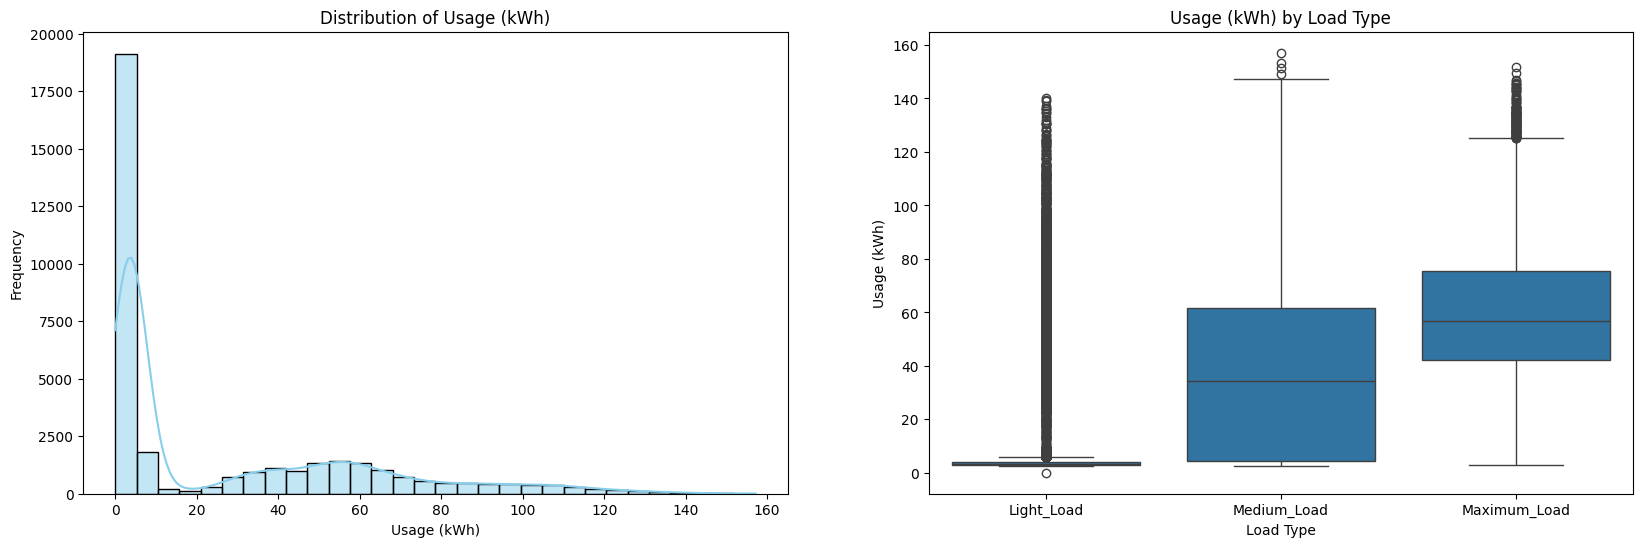

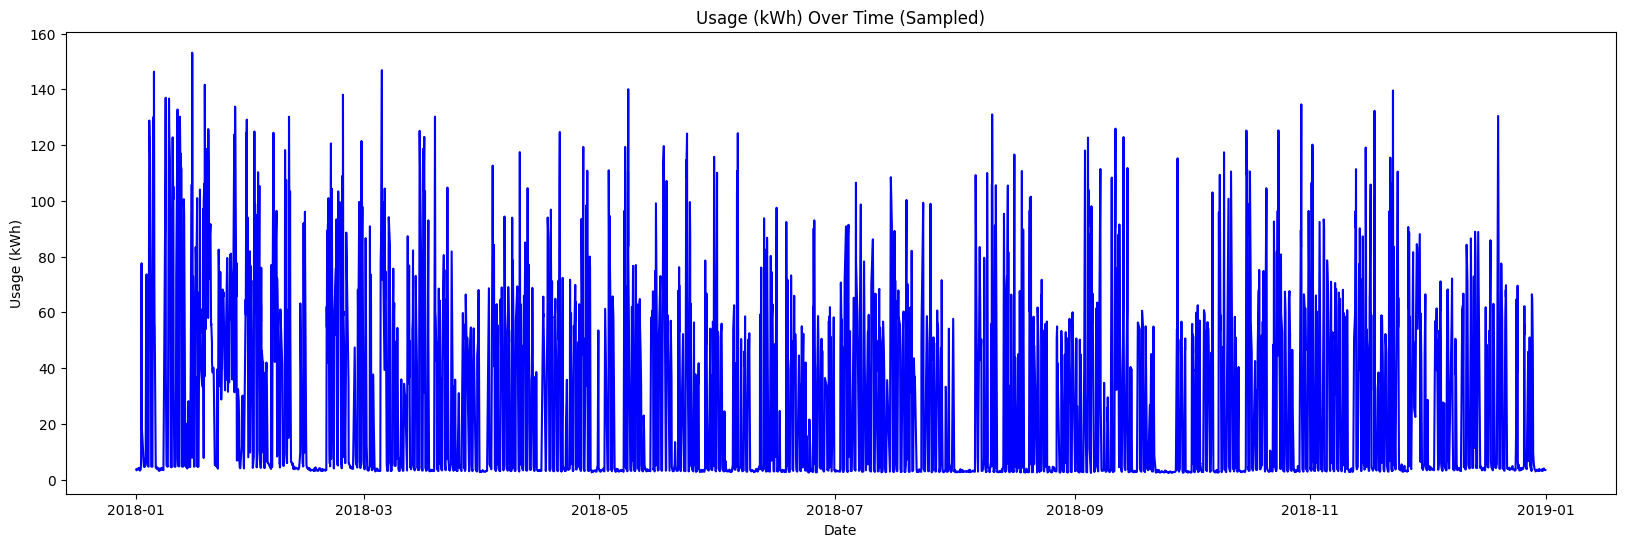

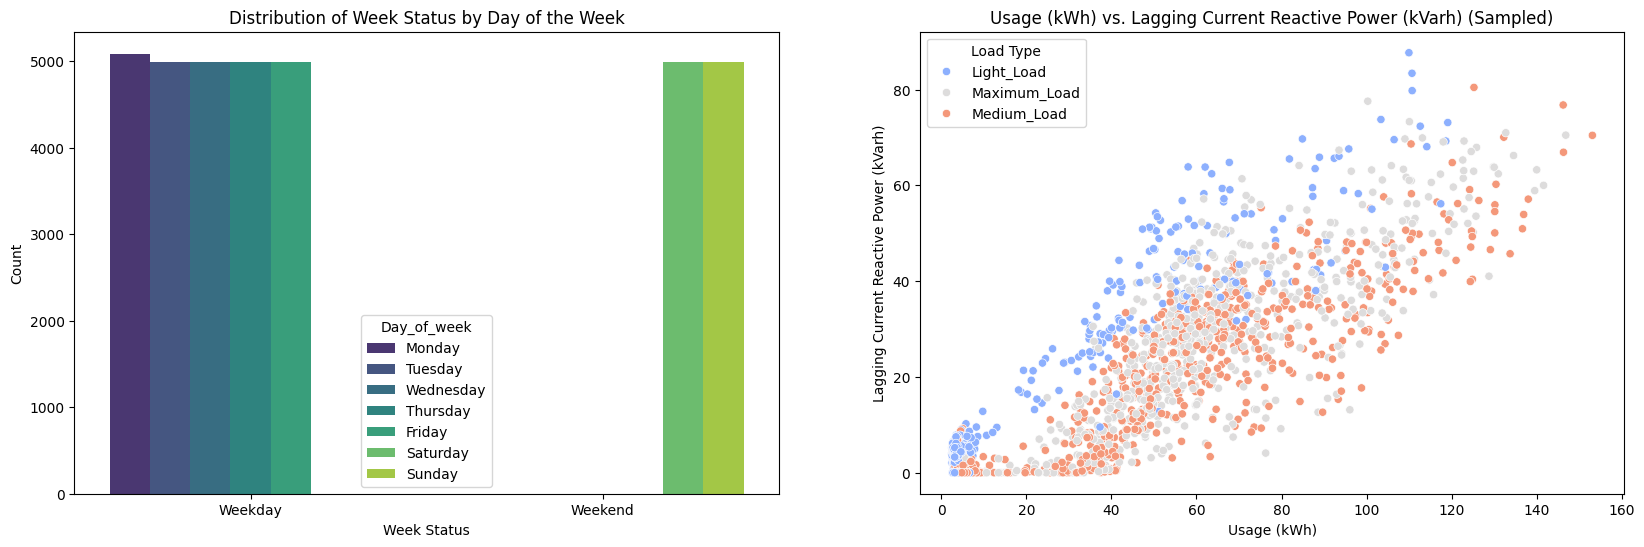

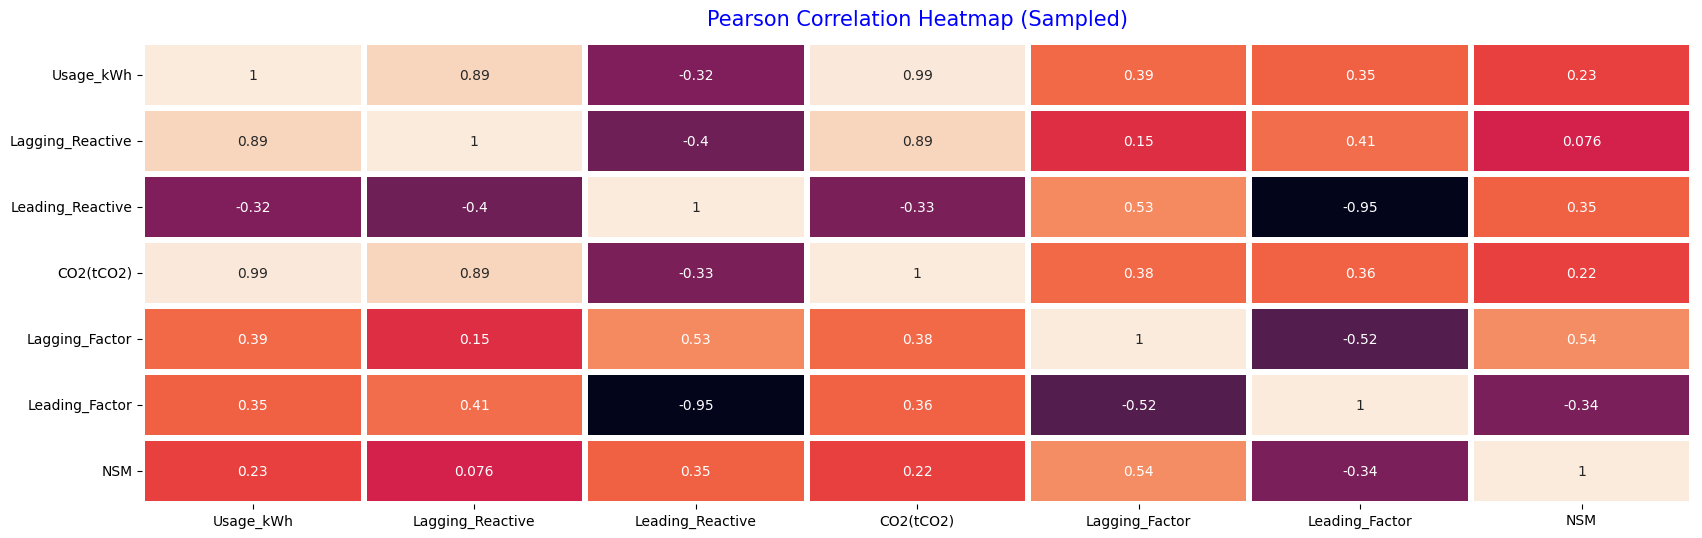

In [11]:
# Plot
# Visualization functions, with samples
def plot_usage_distribution(df):
    sns.histplot(df['Usage_kWh'], bins=30, kde=True, color='skyblue')
    plt.title('Distribution of Usage (kWh)')
    plt.xlabel('Usage (kWh)')
    plt.ylabel('Frequency')


def plot_usage_by_load_type(df):
    sns.boxplot(data=df, x='Load_Type', y='Usage_kWh')
    plt.title('Usage (kWh) by Load Type')
    plt.xlabel('Load Type')
    plt.ylabel('Usage (kWh)')


def plot_usage_over_time(df):
    df_sample = df.sample(frac=0.1, random_state=42)  # Use a 10% sample for line plot
    sns.lineplot(data=df_sample, x='date', y='Usage_kWh', color='blue')
    plt.title('Usage (kWh) Over Time (Sampled)')
    plt.xlabel('Date')
    plt.ylabel('Usage (kWh)')


def plot_week_status_distribution(df):
    sns.countplot(data=df, x='WeekStatus', hue='Day_of_week', palette='viridis')
    plt.title('Distribution of Week Status by Day of the Week')
    plt.xlabel('Week Status')
    plt.ylabel('Count')


def plot_correlation_heatmap(df):
    df_sample = df.sample(frac=0.1, random_state=42)  # Use 10% sample for correlation
    corr_matrix = df_sample.select_dtypes(include=['number']).corr()
    sns.heatmap(corr_matrix, annot=True, linewidths=3, cbar=False)
    plt.title("Pearson Correlation Heatmap (Sampled)", fontsize=15, color='b', pad=12, loc='center')


def plot_usage_vs_reactive_power(df):
    df_sample = df.sample(frac=0.1, random_state=42)  # 10% sample for scatter plot
    sns.scatterplot(data=df_sample, x='Usage_kWh', y='Lagging_Reactive', hue='Load_Type', palette='coolwarm')
    plt.title('Usage (kWh) vs. Lagging Current Reactive Power (kVarh) (Sampled)')
    plt.xlabel('Usage (kWh)')
    plt.ylabel('Lagging Current Reactive Power (kVarh)')
    plt.legend(title='Load Type')


# Main function to execute EDA on a smaller section of the data
def perform_eda(df):
    funcs = [
        [plot_usage_distribution, plot_usage_by_load_type],
        [plot_usage_over_time],
        [plot_week_status_distribution, plot_usage_vs_reactive_power],
        [plot_correlation_heatmap]
    ]
    for i in range(len(funcs)):
        plt.figure(figsize=(20, 6))
        for j in range(len(funcs[i])):
            plt.subplot(1, len(funcs[i]), j + 1)
            funcs[i][j](df)
        plt.show()

perform_eda(df)

In [12]:
df_num.columns

Index(['Usage_kWh', 'Lagging_Reactive', 'Leading_Reactive', 'CO2(tCO2)',
       'Lagging_Factor', 'Leading_Factor', 'NSM'],
      dtype='object')

Сильно скоррелированные признаки:
1. Usage_kWh и CO2(tCO2) - почти 100%
2. **Leading**_Reactive и **Leading**_Factor - 95%
3. Usage_kWh и **Lagging**_Reactive - 89%
4. CO2(tCO2) и **Lagging**_Reactive - 89%

Так как Usage_kWh это целевая переменная, то получается Usage_kWh и CO2(tCO2) линейно-зависимы

## Density

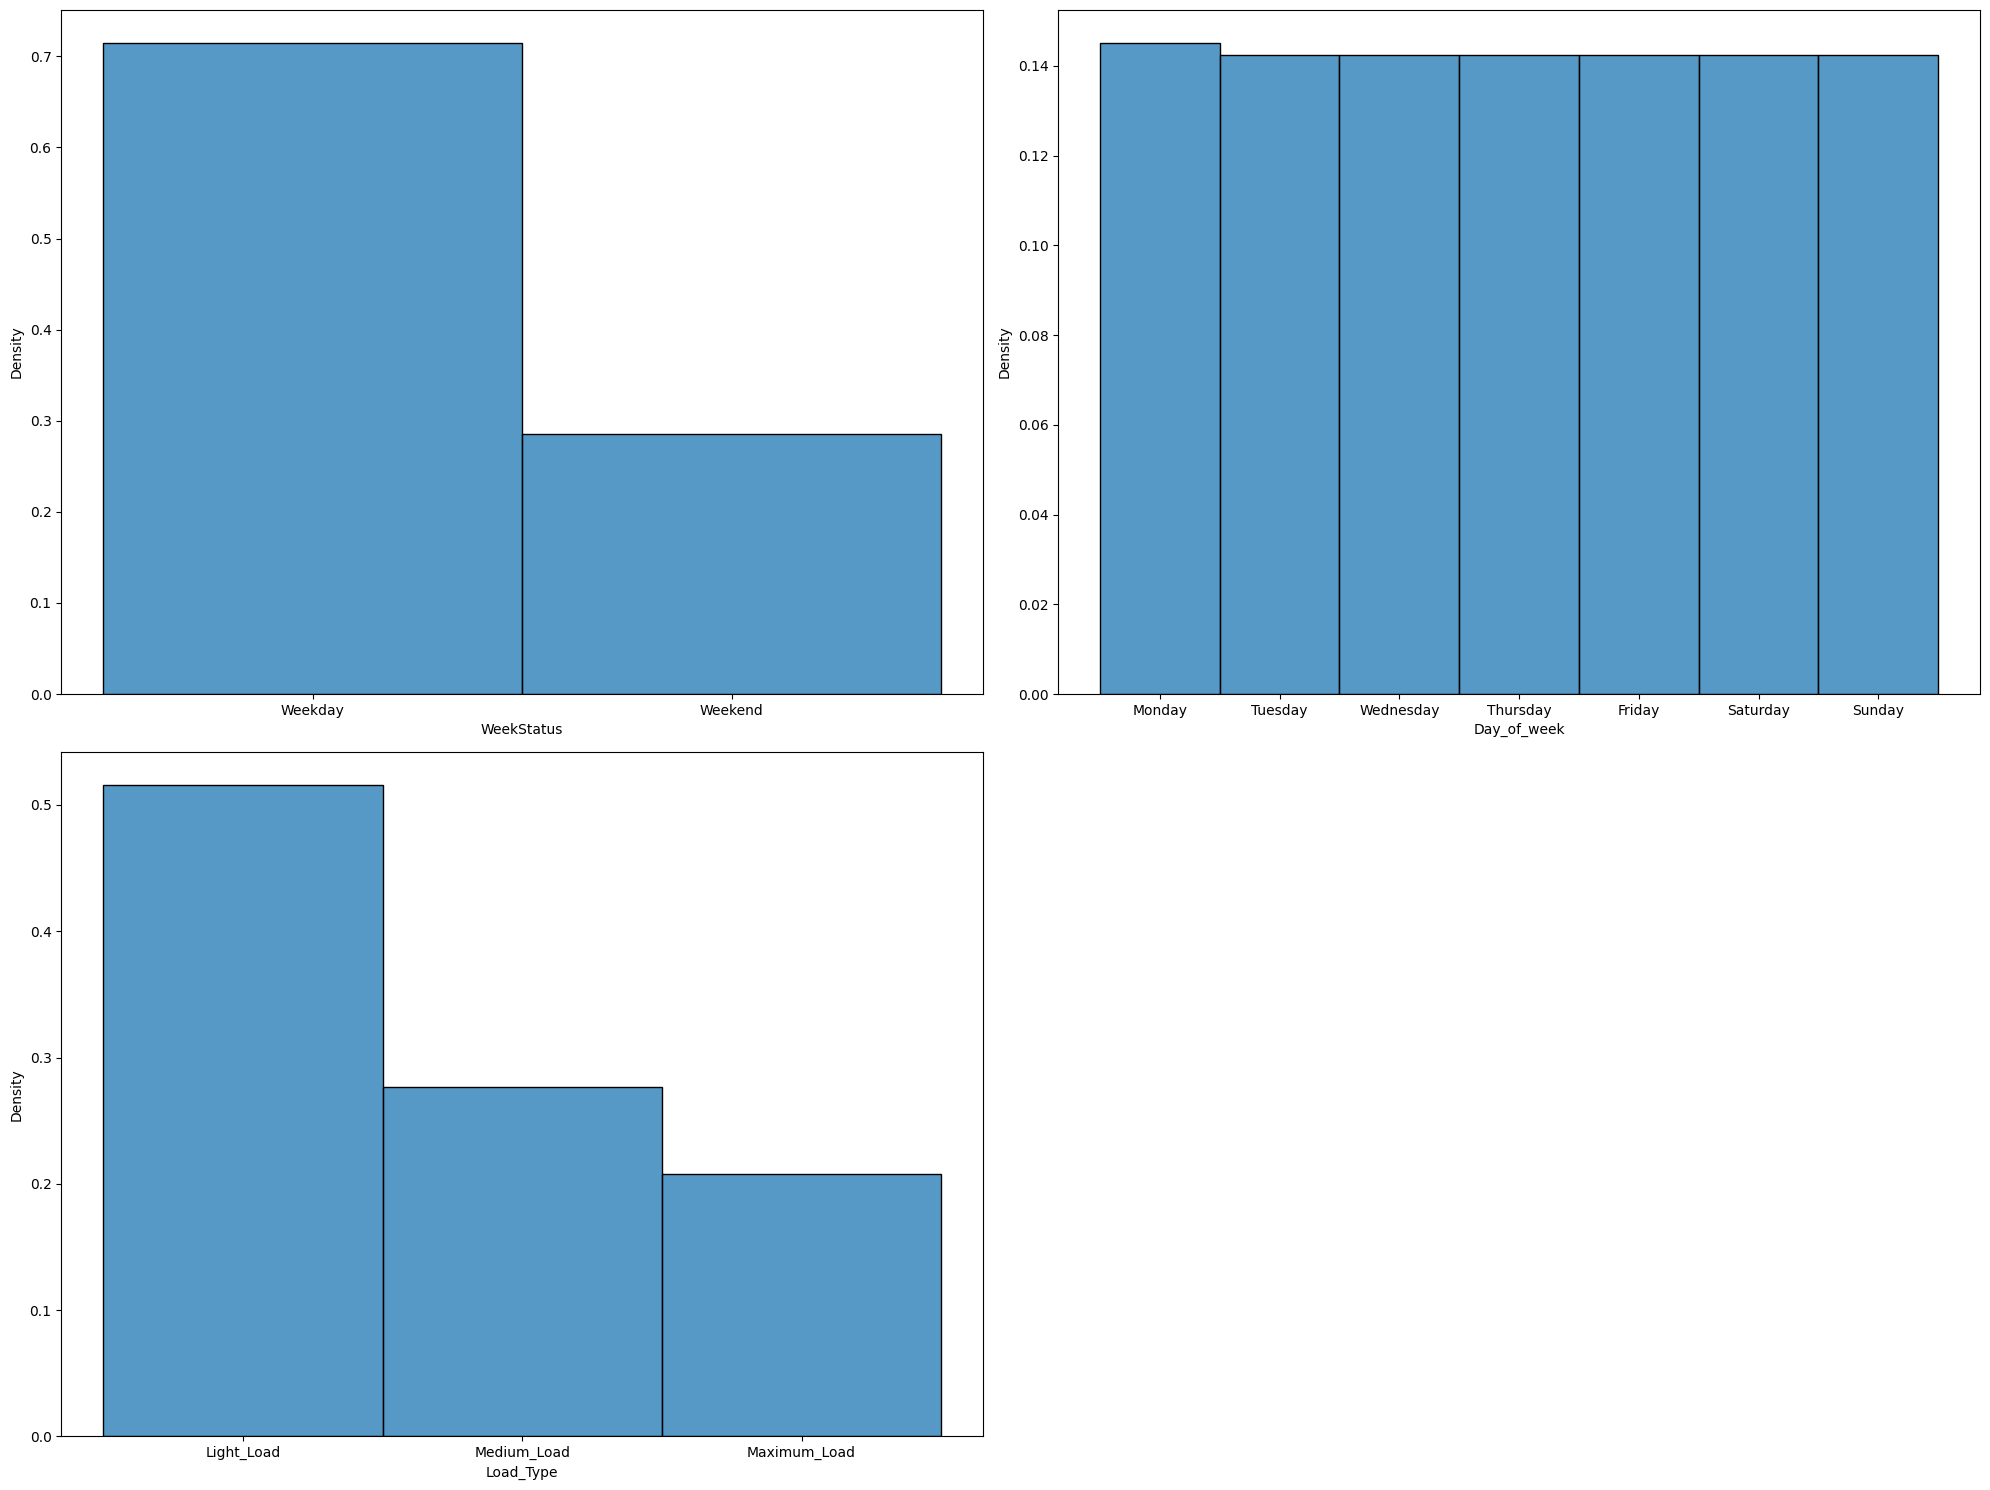

In [13]:
# Density of categorical features

cnt_cols = len(df_cat.columns)
_rows = int(np.ceil(np.sqrt(cnt_cols)))
_cols = int(np.ceil(cnt_cols / _rows))

plt.figure(figsize=(20, 15))

for i, col in enumerate(df_cat.columns):
    plt.subplot(_rows, _cols, i + 1)
    sns.histplot(df[col], stat="density")

plt.tight_layout()
plt.show()

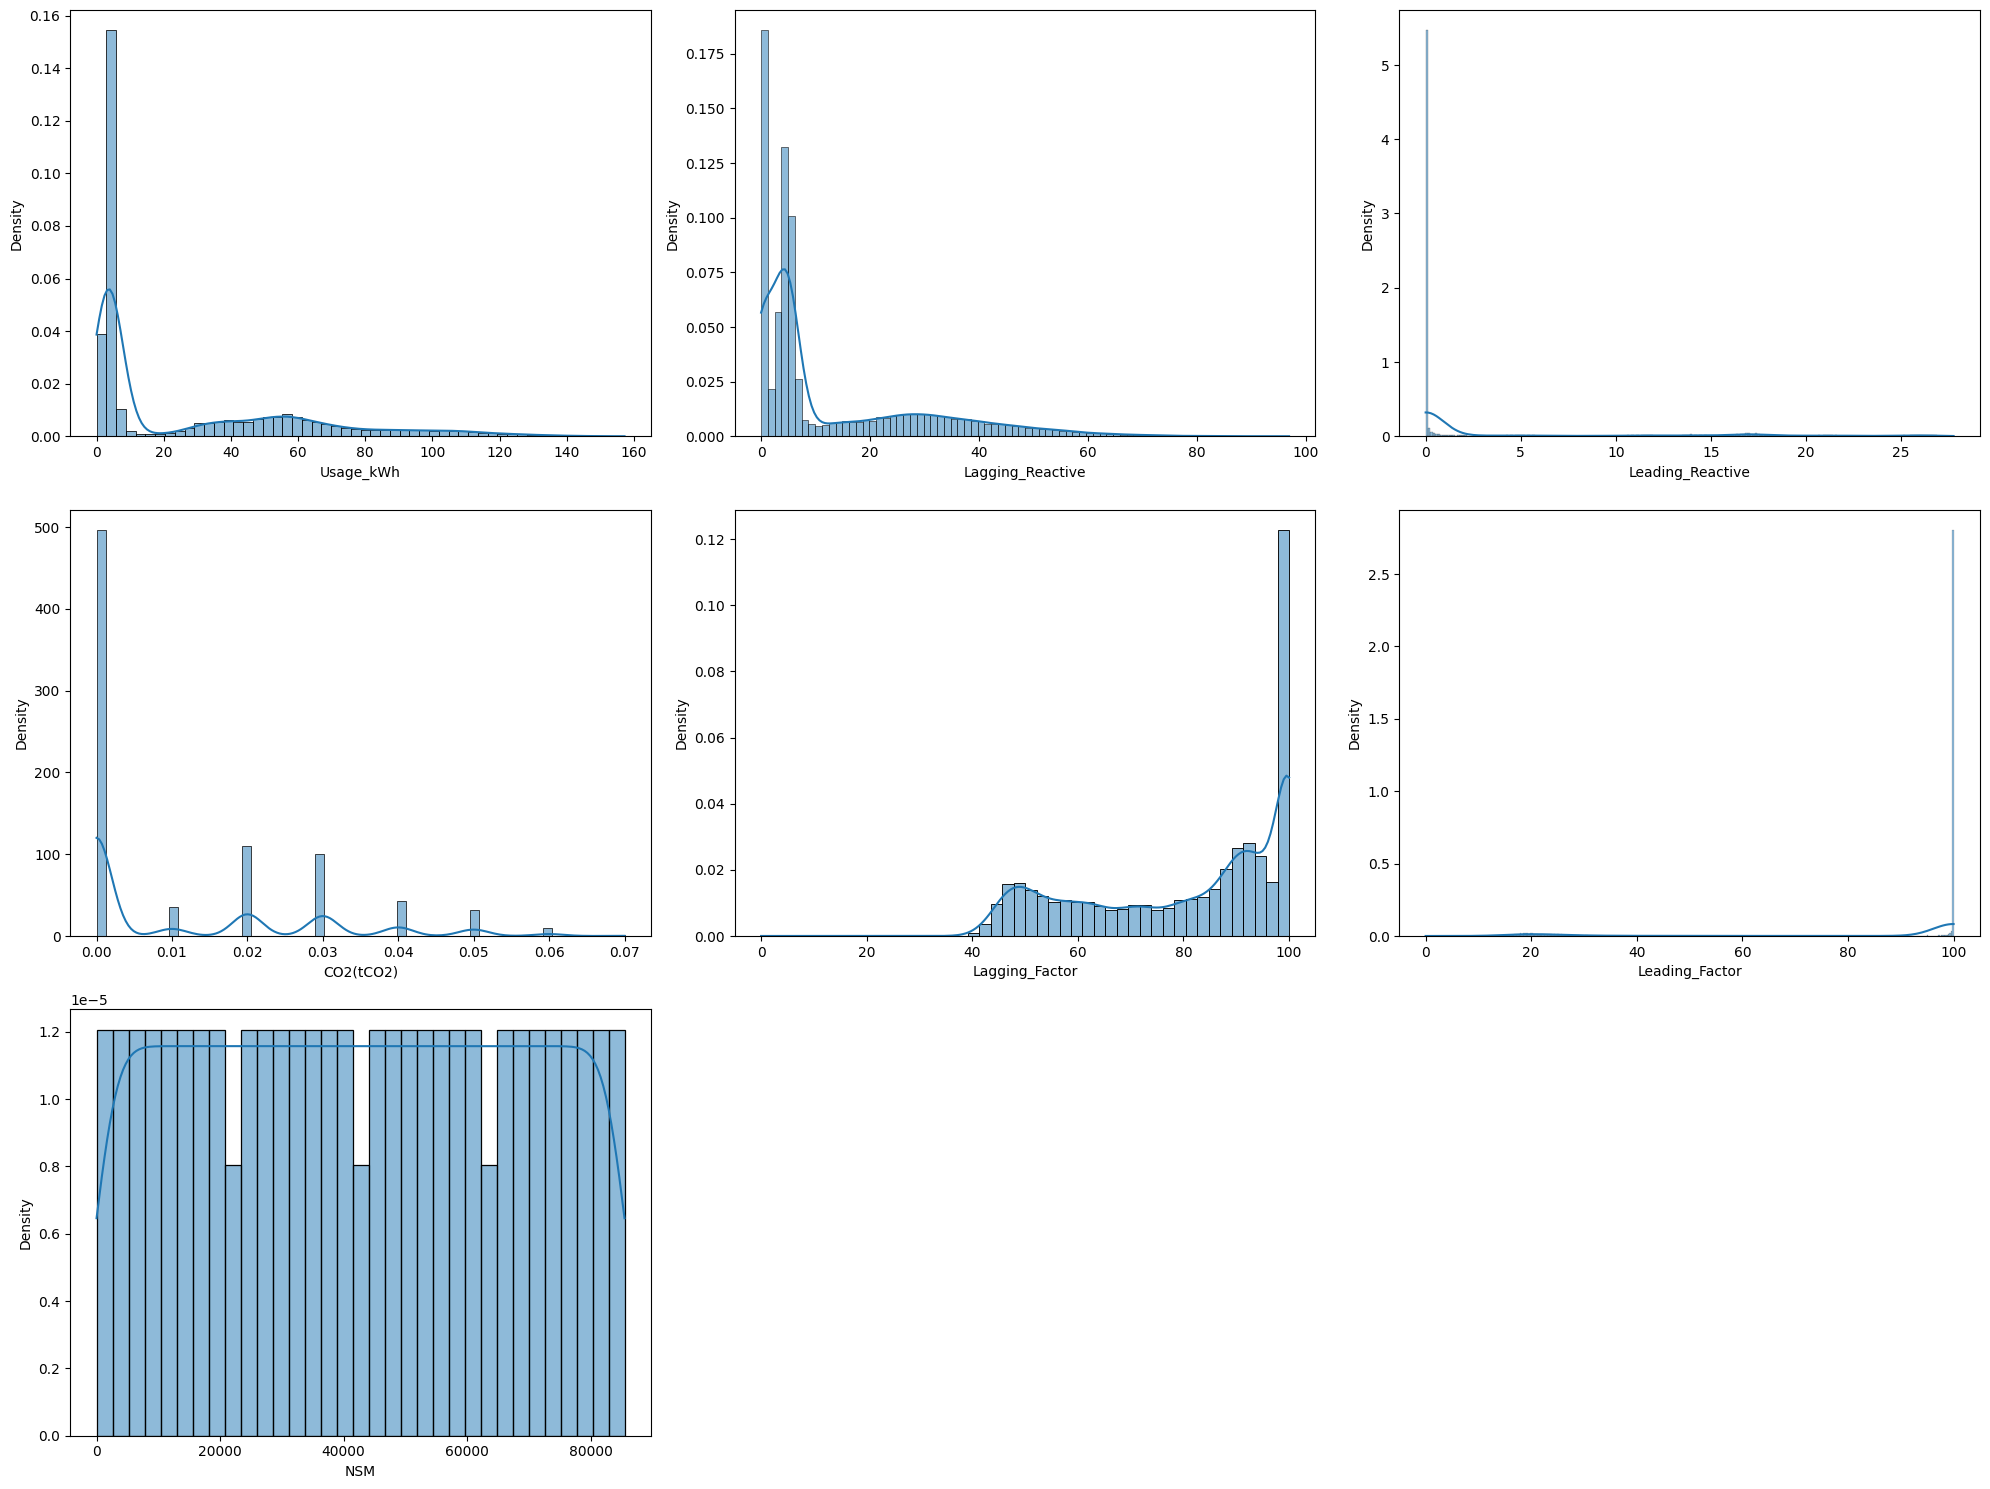

In [14]:
# Density of numeric features

cnt_cols = len(df_num.columns)
_rows = int(np.ceil(np.sqrt(cnt_cols)))
_cols = int(np.ceil(cnt_cols / _rows))

plt.figure(figsize=(20, 15))

for i, col in enumerate(df_num.columns):
    plt.subplot(_rows, _cols, i + 1)
    sns.histplot(df[col], kde=True, stat="density")

plt.tight_layout()
plt.show()

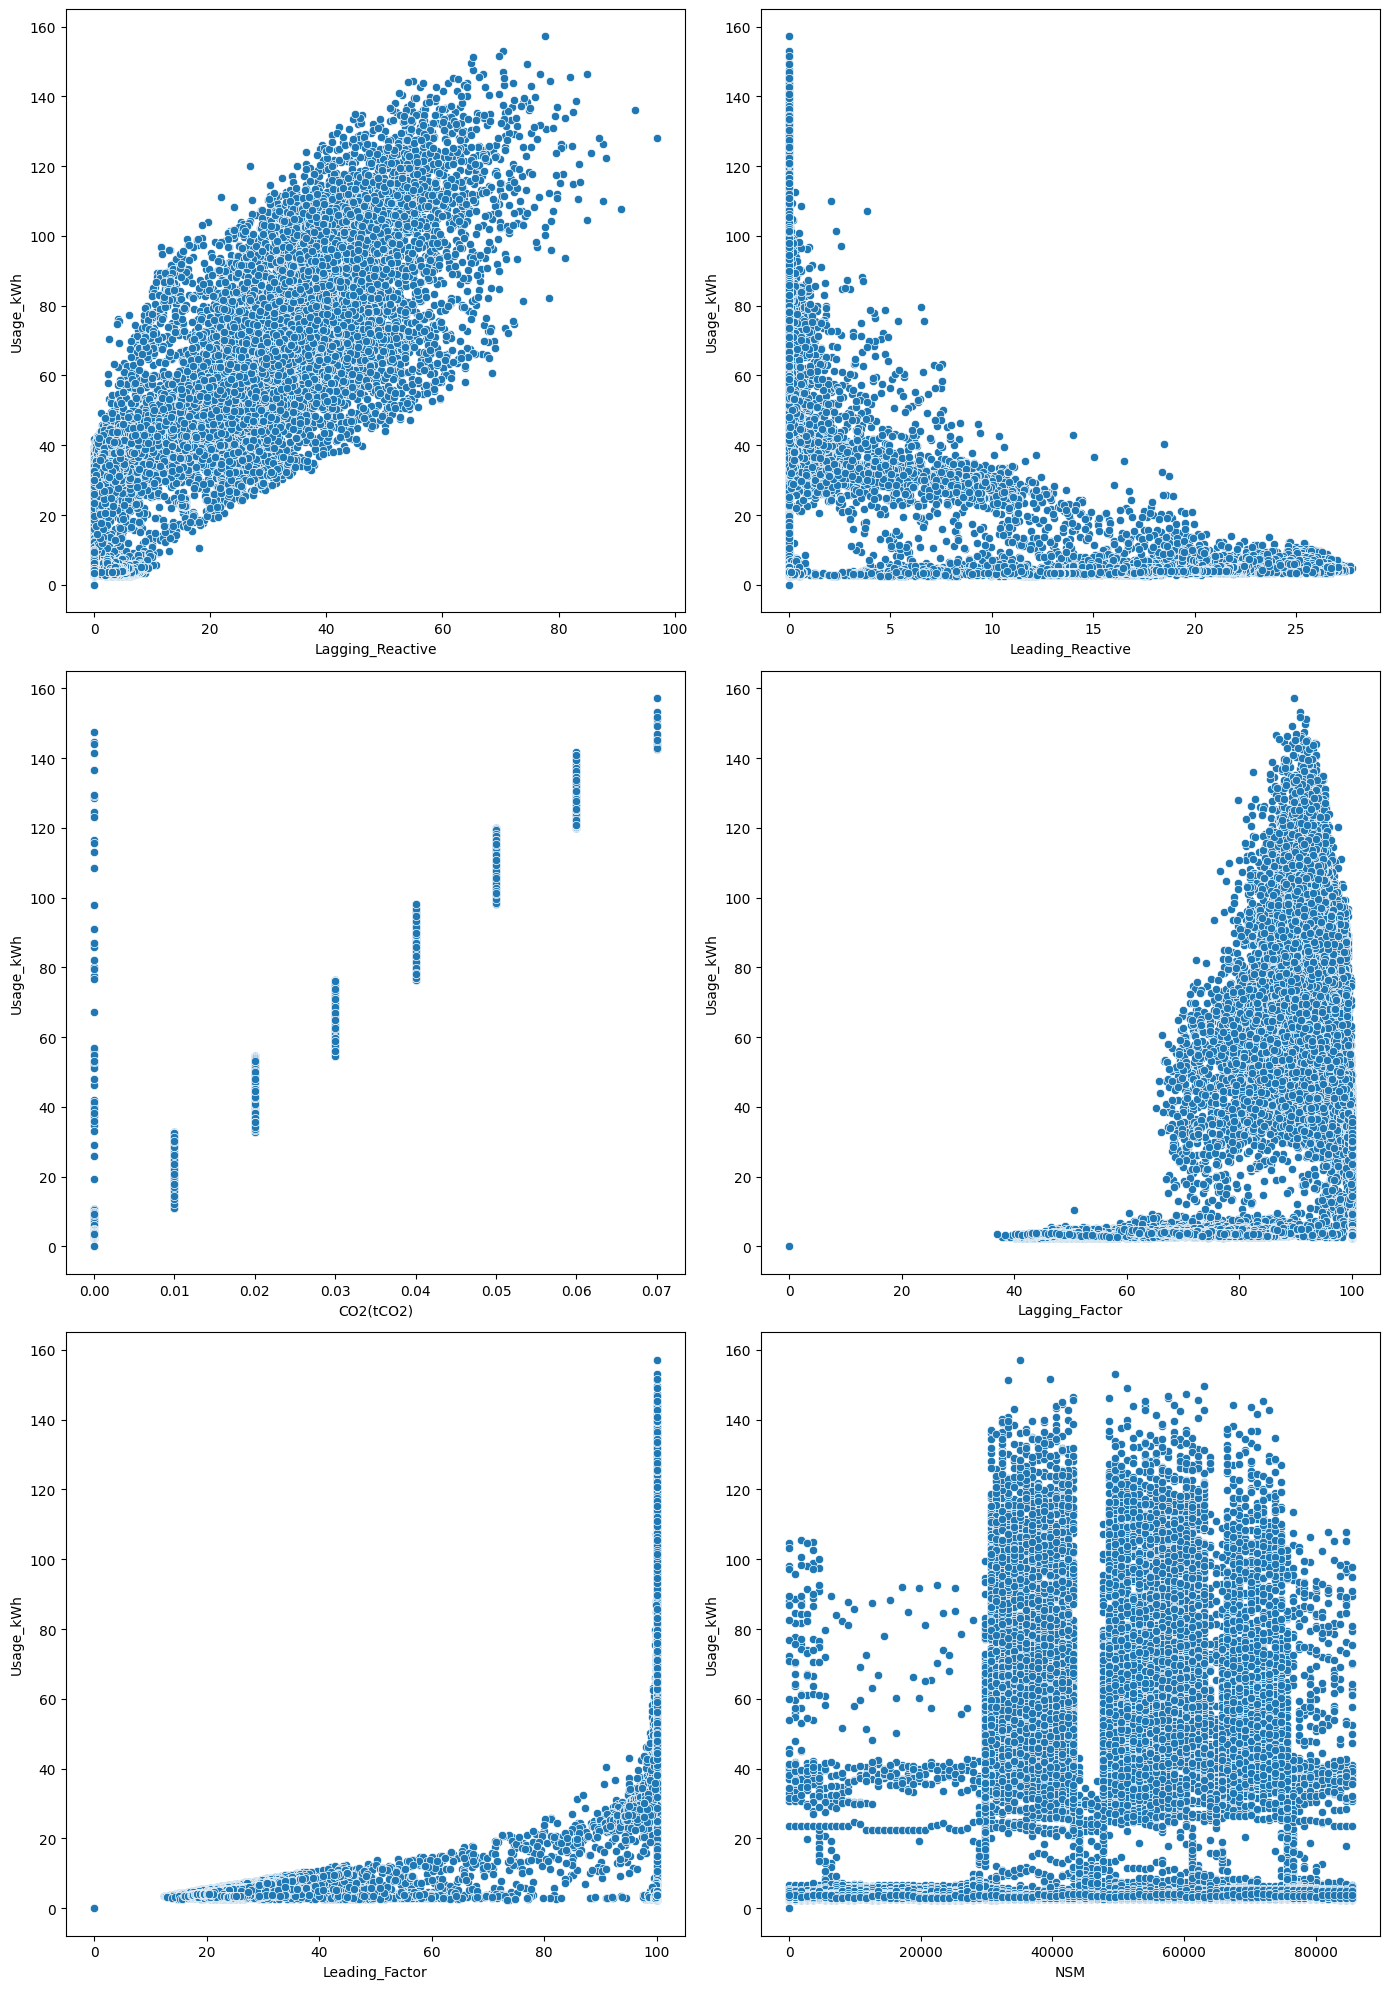

In [15]:
plt.figure(figsize=(14, 20))
idx = 1

for i in df_num.columns:
    if i != 'Usage_kWh':
        plt.subplot(3, 2, idx)
        idx += 1
        sns.scatterplot(data=df, y='Usage_kWh', x=i)

plt.tight_layout()
plt.show()

## Features importance

In [16]:
df1 = df.copy()

le = LabelEncoder()

for column_name in df_cat.columns:    
    df1[column_name] = le.fit_transform(df1[column_name])

df1.head()

,date,Usage_kWh,Lagging_Reactive,Leading_Reactive,CO2(tCO2),Lagging_Factor,Leading_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,0,1,0
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,0,1,0
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,0,1,0
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,0,1,0
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,0,1,0


In [17]:
rf_X = df1.drop(['date', 'Usage_kWh'], axis=1)
rf_y = df1['Usage_kWh']

clf = RandomForestRegressor(criterion='squared_error', random_state=41)
clf.fit(rf_X, rf_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


<Axes: >

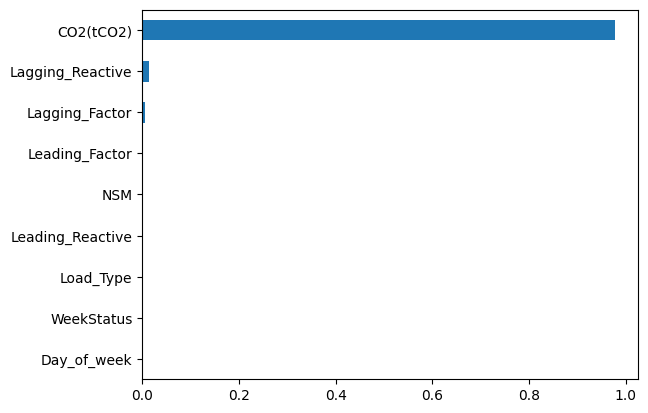

In [18]:
feat_importances = pd.Series(clf.feature_importances_, index=rf_X.columns)
feat_importances.sort_values().plot(kind='barh')

Таким образом, помня сильно скоррелированные группы:

1. Из CO2(tCO2) и **Lagging**_Reactive можно оставить оба
2. Из **Leading**_Reactive и **Leading**_Factor можно оставить **Leading**_Factor

# Preprocess data

In [19]:
drop_deatures = ["Leading_Reactive"]

df = df.drop(drop_deatures, axis=1)

In [20]:
df = df.sort_values("date")
df.head()

,date,Usage_kWh,Lagging_Reactive,CO2(tCO2),Lagging_Factor,Leading_Factor,NSM,WeekStatus,Day_of_week,Load_Type
95,2018-01-01 00:00:00,3.42,3.46,0.0,70.30,100.0,0,Weekday,Monday,Light_Load
0,2018-01-01 00:15:00,3.17,2.95,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,2018-01-01 00:30:00,4.00,4.46,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,2018-01-01 00:45:00,3.24,3.28,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,2018-01-01 01:00:00,3.31,3.56,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load


In [21]:
X = df.drop('Usage_kWh', axis=1)
y = df['Usage_kWh'].to_numpy()

In [22]:
y = np.expand_dims(y, axis=-1)
print(y.shape)

(35040, 1)


In [23]:
# One-Hot Encoding for features
onehot_encoder = OneHotEncoder(drop='first')
X_cat_encoded = onehot_encoder.fit_transform(X[df_cat.columns]).toarray()
print(X_cat_encoded.shape)

(35040, 9)


In [24]:
X_num = X.select_dtypes(include='number').to_numpy()
X = np.concat([X_num, X_cat_encoded], axis=-1)
X.shape

(35040, 14)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    shuffle=False
)

In [26]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
# Split on blocks
NUM_DAYS = 3
MESUREMENTS_PER_HOUR = 4 # 4 times/hour
MESUREMENTS_PER_DAY = MESUREMENTS_PER_HOUR * 24 # 24 hours
BLOCK_SIZE = MESUREMENTS_PER_DAY * NUM_DAYS  # take mesurements for NUM_DAYS days in one block

print("BLOCK_SIZE:", BLOCK_SIZE)

BLOCK_SIZE: 288


In [28]:
def split_on_blocks(X, y):
    NUM_BLOCKS = X.shape[0] // BLOCK_SIZE

    X_blocks = []
    y_blocks = []
    for offset_hours in range(NUM_DAYS * 24):
        offset = offset_hours * MESUREMENTS_PER_HOUR
        if NUM_BLOCKS * BLOCK_SIZE + offset <= X.shape[0]:
            X_blocks += np.split(X[offset:NUM_BLOCKS * BLOCK_SIZE + offset], NUM_BLOCKS)
            y_blocks += list(y[BLOCK_SIZE -1 + offset:NUM_BLOCKS * BLOCK_SIZE + offset:BLOCK_SIZE])
        else:
            X_blocks += np.split(X[offset:(NUM_BLOCKS - 1) * BLOCK_SIZE + offset], NUM_BLOCKS - 1)
            y_blocks += list(y[BLOCK_SIZE -1 + offset:(NUM_BLOCKS -1) * BLOCK_SIZE + offset:BLOCK_SIZE])
    
    X_blocks = np.array(X_blocks)
    y_blocks = np.array(y_blocks)
    return X_blocks, y_blocks


X_train, y_train = split_on_blocks(X_train, y_train)
X_test, y_test = split_on_blocks(X_test, y_test)

print("X train blocks:", X_train.shape)
print("y train blocks:", y_train.shape)
print("X test blocks:", X_test.shape)
print("y test blocks:", y_test.shape)

X train blocks: (6061, 288, 14)
y train blocks: (6061, 1)
X test blocks: (2557, 288, 14)
y test blocks: (2557, 1)


In [29]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.1, 
    shuffle=False
)

In [30]:
print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (5454, 288, 14)
Val shape: (607, 288, 14)
Test shape: (2557, 288, 14)


# Modeling

## Common (utils)

In [31]:
def get_object(types_dict: Dict[str, type], obj: Union[str, object], base_type: type, default: str):
    if obj is None or isinstance(obj, str):
        obj = obj or default
        return types_dict[obj.lower()]()
    elif isinstance(obj, base_type):
        return obj
    else:
        raise RuntimeError(f"Param should be an instance of base {base_type}, string or None")

## Activation functions

In [32]:
# Base abstract Activation class

class Activation:
    NAME = None

    def call(self, x):
        raise NotImplementedError("Call not impelemted")

    def derivative(self, out):
        raise NotImplementedError("Derivative not impelemted")

    def __call__(self, x):
        return self.call(x)

    def __str__(self):
        return self.NAME

In [33]:
class Linear(Activation):
    NAME = "linear"

    def call(self, x):
        return x

    def derivative(self, out):
        return 1

In [34]:
class Sigmoid(Activation):
    NAME = "sigmoid"

    def __init__(self, clip_limit: Optional[Union[int, float]] = 250):
        self.clip_limit = -clip_limit if clip_limit is not None and clip_limit < 0 else clip_limit

    def call(self, x):
        x = np.clip(x, -self.clip_limit, self.clip_limit) if self.clip_limit else x
        return 1 / (1 + np.exp(-x))

    def derivative(self, out):
        return out * (1 - out)

In [35]:
class Tanh(Activation):
    NAME = "tanh"

    # @njit(cache=True,fastmath=True)
    def call(self, x):
        return np.tanh(x)

    def derivative(self, out):
        return 1. - out**2

In [36]:
class ReLU(Activation):
    NAME = 'relu'
    
    def call(self, x):
        return np.maximum(0, x)
    
    def derivative(self, out):
        return (out > 0).astype(float)

In [37]:
class SiLU(Activation):
    NAME = "silu"
    
    def __init__(self, clip_limit: Optional[Union[int, float]] = 250):
        self.sigmoid = Sigmoid(clip_limit)
        self.x_sigm = None    # bhee

    def call(self, x):
        self.x_sigm = self.sigmoid(x)
        return x * self.x_sigm

    def derivative(self, out):
        return self.x_sigm * (1. - out) + out

In [38]:
class StableSoftmax(Activation):
    """More numerically stable softmax implementation"""
    NAME = 'stable_softmax'

    def call(self, x):
        """Numerically stable softmax"""
        stable_x = x - np.max(x, axis=-1, keepdims=True)
        exp_x = np.exp(stable_x)
        return exp_x / (np.sum(exp_x, axis=-1, keepdims=True) + 1e-8)

    def derivative(self, out):
        return out

In [39]:
# Find all classes based on Activation class
ACTIVATIONS = {
    v.NAME: v 
    for v in globals().values() 
    if isinstance(v, type) and Activation in v.__bases__
}

print(ACTIVATIONS)

{'linear': <class '__main__.Linear'>, 'sigmoid': <class '__main__.Sigmoid'>, 'tanh': <class '__main__.Tanh'>, 'relu': <class '__main__.ReLU'>, 'silu': <class '__main__.SiLU'>, 'stable_softmax': <class '__main__.StableSoftmax'>}


## Layers

### Other layers

In [40]:
class BaseLayer:
    def __init__(self, input_size, output_size, activation='linear'):
        self.input_size = input_size
        self.output_size = output_size
        self.activation = get_object(ACTIVATIONS, activation, base_type=Activation, default='linear')
        # Train params
        self.weights = None
        self.bias = None
        self.init_weights()
        
        self.name = str(uuid4())

    def init_weights(self):
        raise NotImplementedError("Init weights not impelemted")

    @property
    def num_params(self):
        raise NotImplementedError("Number of parameters not impelemted")

    def forward(self, X):
        raise NotImplementedError("Forward not impelemted")

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def backward(self, X, output, doutput):
        raise NotImplementedError("Backward not impelemted")

In [41]:
class Dense(BaseLayer):
    def init_weights(self):
        self.weights = np.random.normal(
            scale=2./(self.input_size + self.output_size), 
            size=(self.input_size, self.output_size)
        )
        self.bias = np.random.normal(
            scale=2/(self.input_size + self.output_size), 
            size=(1, self.output_size)
        )

    @property
    def num_params(self):
        return (self.input_size + 1) * self.output_size
    
    def forward(self, X):
        output = np.dot(X, self.weights) + self.bias
        output = self.activation(output)

        return output

    def __call__(self, X):
        return self.forward(X)

    def backward(self, X, output, doutput):
        # Activation function gradient
        doutput = doutput * self.activation.derivative(output)
        # Next grdients calculation
        dinput = np.dot(doutput, self.weights.T)
        dweights = np.dot(X.T, doutput)
        dbias = np.sum(doutput, axis=0, keepdims=True)

        return dinput, {"weights": dweights, "bias": dbias}

In [42]:
class Base2DLayer(BaseLayer):
    def __init__(self, input_size, output_channels, window_size, stride=None, padding=0, activation='linear'):
        # input_size: (channels, height, width)
        self.input_size = input_size
        self.input_channels, self.input_height, self.input_width = input_size

        self.window_size = window_size if isinstance(window_size, tuple) else (window_size, window_size)
        self.stride = stride if isinstance(stride, tuple) else (stride, stride)
        self.padding = padding if isinstance(padding, tuple) else (padding, padding)

        # Calculate output dimensions
        self.output_channels = output_channels
        self.output_height = (self.input_height + 2 * self.padding[0] - self.window_size[0]) // self.stride[0] + 1
        self.output_width = (self.input_width + 2 * self.padding[1] - self.window_size[1]) // self.stride[1] + 1
        self.output_size = (self.output_channels, self.output_height, self.output_width)

        # Initialize base class
        super().__init__(self.input_size, self.output_size, activation)

    def _pad_input(self, X):
        """Apply padding to input"""
        if self.padding[0] == 0 and self.padding[1] == 0:
            return X
            
        return np.pad(X, 
            (
                (0, 0), (0, 0), # Batch and channels without pad
                (self.padding[0], self.padding[0]),
                (self.padding[1], self.padding[1]) 
            ), 
            mode='constant'
        )

    def _get_receptive_field_borders(self, i, j):
        h_start = i * self.stride[0]
        h_end = h_start + self.window_size[0]
        w_start = j * self.stride[1]
        w_end = w_start + self.window_size[1]
        return (h_start, w_start), (h_end, w_end)

    def _window_slide(self, X):
        X_padded = self._pad_input(X)

        # Slide through image
        for i in range(self.output_height):
            for j in range(self.output_width):
                # Extract receptive field
                (h_start, w_start), (h_end, w_end) = self._get_receptive_field_borders(i, j)
                receptive_field = X_padded[:, :, h_start:h_end, w_start:w_end]
                yield i, j, receptive_field

In [43]:
class Conv2D(Base2DLayer):
    def __init__(self, input_size, output_channels, kernel_size, stride=1, padding=0, activation='linear'):
        super().__init__(input_size, output_channels, kernel_size, stride, padding, activation)

        self.kernel_size = self.window_size
    
    def init_weights(self):
        # He initialization
        kernel_params = self.window_size[0] * self.window_size[1]
        scale = np.sqrt(2.0/ (self.input_channels * kernel_params))

        self.weights = np.random.normal(
            scale=scale,
            size=(
                self.output_channels, 
                self.input_channels, 
                *self.window_size
            )
        )
        self.bias = np.random.normal(scale=scale, size=self.output_channels)

    @property
    def num_params(self):
        weights_params = np.prod(self.weights.shape)
        bias_params = self.output_channels
        return weights_params + bias_params

    
    def forward(self, X):
        """
        Forward pass for Conv2D
        X shape: (batch_size, input_channels, input_height, input_width)
        Returns: (batch_size, output_channels, output_height, output_width)
        """
        # Initialize output
        output = np.zeros((X.shape[0], *self.output_size))

        for i, j, receptive_field in self._window_slide(X):
            # Convolve with all filters
            for k in range(self.output_channels):
                # Element-wise multiplication and sum
                output[:, k, i, j] = np.sum(
                    receptive_field * self.weights[k, np.newaxis], 
                    axis=(1, 2, 3)
                ) + self.bias[k]
    
        output = self.activation(output)
        
        return output


    def backward(self, X, output, doutput):
        """
        Backward pass for Conv2D
        X: Previous input to the layer 
        output: Output from forward pass (after activation)
        doutput: Gradient from next layer
        Returns: dinput and dict to update weights
        """
        # Gradient through activation
        doutput = doutput * self.activation.derivative(output)

        # Initialize gradients
        dinput = np.zeros_like(self._pad_input(X))
        dweights = np.zeros_like(self.weights)
        dbias = np.zeros_like(self.bias)
        
        for i, j, receptive_field in self._window_slide(X):
            for k in range(self.output_channels):
                # Gradients for input
                (h_start, w_start), (h_end, w_end) = self._get_receptive_field_borders(i, j)
                dinput[:, :, h_start:h_end, w_start:w_end] += (
                     doutput[:, k:k+1, i:i+1, j:j+1] * self.weights[k]
                )
    
                # Weights gradients
                dweights[k] += np.sum(
                    receptive_field * doutput[:, k:k+1, i:i+1, j:j+1], # Save axis
                    axis=0
                )
            dbias += np.sum(doutput[:, :, i, j], axis=0)

        # Average gradients over batch
        dweights /= X.shape[0]
        dbias /= X.shape[0]

        # Remove padding from dinput gradient
        if self.padding[0] > 0 and self.padding[1] > 0:
            dinput = dinput[:, :, self.padding[0]:-self.padding[0], self.padding[1]:-self.padding[1]]
        elif self.padding[0] > 0:
            dinput = dinput[:, :, self.padding[0]:-self.padding[0], :]
        elif self.padding[1] > 0:
            dinput = dinput[:, :, :, self.padding[1]:-self.padding[1]]

        return dinput, {"weights": dweights, "bias": dbias}

In [44]:
class MaxPool2D(Base2DLayer):
    def __init__(self, input_size, pool_size=2, stride=None, padding=0):
        """
        Max Pooling 2D Layer
        
        Args:
            pool_size: int or tuple, size of the pooling window
            stride: int or tuple, stride of the pooling operation. If None, defaults to pool_size
            padding: int or tuple, padding to apply to input
        """
        super().__init__(input_size, input_size[0], pool_size, stride or pool_size, padding)

        self.pool_size = self.window_size        
        # Store for backward pass
        self.max_indices = None
        self._window_chan_inds = np.array(
            np.unravel_index(
                np.arange(self.output_channels * np.prod(self.pool_size)), 
                shape=(self.output_channels, *self.pool_size)
            )
        )

    def init_weights(self):
        """Pooling layer have no trainable parameters"""
        pass

    @property
    def num_params(self):
        """Pooling layer have no trainable parameters"""
        return 0

    def forward(self, X):
        """
        Forward pass for MaxPool2D
        
        Args:
            X: input data with shape: (batch_size, channels, height, width)
        Returns: 
            output with shape (batch_size, channels, output_height, output_width)
        """
        batch_size = X.shape[0]

        # Initialize output
        output = np.zeros((batch_size, self.output_channels, self.output_height, self.output_width))
        
        # Store indices of max values for backward pass
        
        self.max_indices = np.zeros((*output.shape, 2), dtype=int)
        
        for i, j, window in self._window_slide(X):
            maxes = np.max(window, axis=(2, 3), keepdims=True)
            output[:, :, i, j] = maxes.reshape((batch_size, self.output_channels))
            
            # Save max indices
            mask = (window == maxes).reshape((batch_size, np.prod(window.shape[1:])))
        
            for b in range(batch_size):
                sample_indices = self._window_chan_inds[:, mask[b]] # [[channel indexes], [row indexes], [col indexes]]
                self.max_indices[b, sample_indices[0], i, j, 0] = sample_indices[1] + i * self.stride[0]
                self.max_indices[b, sample_indices[0], i, j, 1] = sample_indices[2] + j * self.stride[1]

        return output

    def backward(self, X, output, doutput):
        """
        Backward pass for MaxPool2D
        
        Args:
            X: Previous input to the layer 
            output: Output from forward pass (after activation), not used
            doutput: Gradient from next layer        
        Returns:
            dinput: Input gradient, shape (batch_size, channels, input_height, input_width)
        """
        if self.max_indices is None:
            output = self.forward(X)

        batch_size = X.shape[0]
        
        # Initialize gradient with respect to input (padded)
        dinput = np.zeros_like(self._pad_input(X))

        # Distribute gradients only to positions that were selected during max pooling
        # TODO rewrite
        for b in range(batch_size):
            for c in range(self.output_channels):
                for i in range(self.output_height):
                    for j in range(self.output_width):
                        h_idx, w_idx = self.max_indices[b, c, i, j]
                        dinput[b, c, h_idx, w_idx] += doutput[b, c, i, j]

        # Remove padding from gradient
        if self.padding[0] > 0 and self.padding[1] > 0:
            dinput = dinput[:, :, self.padding[0]:-self.padding[0], self.padding[1]:-self.padding[1]]
        elif self.padding[0] > 0:
            dinput = dinput[:, :, self.padding[0]:-self.padding[0], :]
        elif self.padding[1] > 0:
            dinput = dinput[:, :, :, self.padding[1]:-self.padding[1]]
    
        return dinput, {}

    def __call__(self, X):
        return self.forward(X)

In [45]:
class Flatten(BaseLayer):
    def init_weights(self):
        """Flatten layer have no trainable parameters"""
        pass

    @property
    def num_params(self):
        """Flatten layer have no trainable parameters"""
        return 0

    def forward(self, X):
        return X.reshape((X.shape[0], self.output_size))

    def backward(self, X, output, doutput):
        input_size = self.input_size if isinstance(self.input_size, tuple) else (self.input_size,)
        dinput = doutput.reshape((doutput.shape[0], *input_size))
        return dinput, {}

### New layers

In [46]:
class BaseRecurrentLayer(BaseLayer):
    def __init__(self, input_size, output_size, activation='tanh', 
                 return_sequences=True, go_backwards=False, inner_names=None):

        self._weights_names = ("weights", "state_weights", "bias")
        self._inner_names = inner_names
        
        self.return_sequences = return_sequences
        self.go_backwards = go_backwards

        self.cache = None
        self.state_weights = None
        self.grads = {}

        super().__init__(input_size, output_size, activation)

    def init_weights(self):
        num_inner = (len(self._inner_names),) if self._inner_names is not None else tuple()
        
        self.weights = np.random.normal(
            scale=2./(self.input_size + self.output_size), 
            size=num_inner + (self.input_size, self.output_size)
        )
        self.state_weights = np.random.normal(
            scale=2./(self.output_size + self.output_size), 
            size=num_inner + (self.output_size, self.output_size)
        )
        self.bias = np.random.normal(
            scale=2/(self.input_size + self.output_size), 
            size=num_inner + (1, self.output_size)
        )

    def __getattr__(self, attr: str):
        # Define __getattr__ to get needed weights like self.weights_i
        propobj = getattr(self.__class__, attr, None)
        if isinstance(propobj, property):
            return propobj.fget(self)

        if not self._inner_names:
            return

        split_attr = attr.rsplit('_', 1)
        if len(split_attr) != 2:
            return 

        weights_attr, inner_name = split_attr
        if weights_attr in self._weights_names and inner_name in self._inner_names:
            weights_idx = self._inner_names.index(inner_name)
            return getattr(self, weights_attr)[weights_idx]

    @property
    def num_params(self):
        return self.weights.size + self.state_weights.size + self.bias.size

    def init_grads(self, batch_size):
        self.grads = {
            "weights": np.zeros_like(self.weights),
            "state_weights": np.zeros_like(self.state_weights),
            "bias": np.zeros_like(self.bias),
            "_dh": np.zeros((batch_size, self.output_size))
        }

    def get_initial_state(self, batch_size):
        return None
    
    def step(self, x, h_prev, state):
        raise NotImplementedError("Forward step not implemented")
    
    def step_backward(self, dnext_state, cache_t):
        raise NotImplementedError
    
    def forward(self, X, initial_state=None):
        batch_size, timesteps, input_size = X.shape
        
        if self.go_backwards:
            time_range = np.arange(timesteps-1, -1, -1)
        else:
            time_range = np.arange(timesteps)
        
        # Кэш для хранения промежуточных значений
        self.cache = {
            'time_range': time_range,
            'states': [],
            'outputs': []
        }
        state = initial_state or self.get_initial_state(batch_size)
        output = np.zeros((batch_size, self.output_size))

        for t in time_range:
            x_t = X[:, t, :]
            output, state = self.step(x_t, output, state)

            # Сохраняем промежуточные значения для backward
            self.cache['states'].append(state)
            self.cache['outputs'].append(output)

        self.cache['outputs'] = np.stack(self.cache['outputs'], axis=1)  
        if self.return_sequences:
            return self.cache['outputs']
        else:
            return self.cache['outputs'][:, -1, :]

    def backward(self, X, output, doutput):
        """
        Обратное распространение для RNN
        """
        batch_size, timesteps, input_size = X.shape
        
        # Инициализация градиентов
        dX = np.zeros_like(X)
        self.init_grads(batch_size)
    
        # Обратный порядок временных шагов
        time_range_rev = self.cache['time_range'][::-1]
        
        for i, t in enumerate(time_range_rev):
            # Индекс в кэше
            cache_idx = len(time_range_rev) - 1 - i
            
            # Получаем сохраненные значения
            x_t = X[:, cache_idx, :]
            h_t = self.cache['outputs'][:, cache_idx, :]
            st_t = self.cache['states'][cache_idx]
            if cache_idx > 0:
                h_prev = self.cache['outputs'][:, cache_idx - 1, :]
                st_prev = self.cache['states'][cache_idx - 1]
            else:
                h_prev = np.zeros((batch_size, self.output_size))
                st_prev = np.zeros((batch_size, self.output_size))
    
            # Градиент от выхода
            if self.return_sequences:
                doutput_t = doutput[:, t, :]
            else:
                # Если return_sequences=False, градиент только на последнем шаге
                doutput_t = doutput if i == 0 else np.zeros_like(doutput)
    
            # Суммируем градиенты от следующего состояния и выхода
            dnext_h = self.grads["_dh"] + doutput_t
            
            # Обратный проход через шаг
            cache_t = (x_t, h_t, h_prev, st_t, st_prev)
            dx_t = self.step_backward(dnext_h, cache_t)
            
            # Сохраняем градиент по входу
            dX[:, t, :] += dx_t

        # Delete tmp grads
        for _grads_key in list(self.grads.keys()):
            if _grads_key.startswith("_"):
                self.grads.pop(_grads_key)

        return dX, self.grads

In [47]:
class RNNLayer(BaseRecurrentLayer):
    def __init__(self, input_size, output_size, activation='tanh', return_sequences=True, go_backwards=False):
        super().__init__(
            input_size, output_size, activation, return_sequences, go_backwards
        )
    
    def step(self, x, h_prev, state):
        h = np.dot(x, self.weights) + np.dot(h_prev, self.state_weights) + self.bias
        h_activated = self.activation(h)
        return h_activated, state

    def step_backward(self, dnext_h, cache_t):
        """
        Обратный проход для одного шага RNN
        """
        x_t, h_t, h_prev = cache_t[:3]

        # Градиент до активации
        dh = dnext_h * self.activation.derivative(h_t)

        # Градиенты по параметрам
        self.grads["weights"] += np.dot(x_t.T, dh)
        self.grads["state_weights"] += np.dot(h_prev.T, dh)
        self.grads["bias"] += np.sum(dh, axis=0, keepdims=True)

        # Градиенты по входам
        dx_t = np.dot(dh, self.weights.T)
        self.grads["_dh"] = np.dot(dh, self.state_weights.T)
        
        return dx_t

In [48]:
class LSTMLayer(BaseRecurrentLayer):
    def __init__(
        self, input_size, output_size, activation='tanh', 
        recurrent_activation='sigmoid', return_sequences=True, go_backwards=False
    ):
        # Инициализируются 4 матрицы весов:
        # 1. Веса для слоя забывания (f)
        # 2. Веса для слоя входного фильтра (i)
        # 3. Веса для слоя обновления (c)
        # 4. Веса для выходного слоя (o)
        super().__init__(
            input_size, output_size, activation, return_sequences, go_backwards,
            inner_names=("f", "i", "c", "o")
        )
        self.recurrent_activation = get_object(ACTIVATIONS, recurrent_activation, base_type=Activation, default='sigmoid')
    
    def init_grads(self, batch_size):
        super().init_grads(batch_size)
        self.grads["_dc"] = np.zeros((batch_size, self.output_size))

    def get_initial_state(self, batch_size):
        return np.zeros((batch_size, self.output_size))
    
    def step(self, x, h_prev, state):
        c_prev = state[-1] if isinstance(state, tuple) else state

        # Cлой забывания (f)
        f = np.dot(x, self.weights_f) + np.dot(h_prev, self.state_weights_f) + self.bias_f
        f = self.recurrent_activation(f)

        # Слой входного фильтра (i)
        i = np.dot(x, self.weights_i) + np.dot(h_prev, self.state_weights_i) + self.bias_i
        i = self.recurrent_activation(i)

        # Слой обновления (c)
        c_candidate = np.dot(x, self.weights_c) + np.dot(h_prev, self.state_weights_c) + self.bias_c
        c_candidate = self.activation(c_candidate)
    
        # Обновляем ячейку состояния
        c = f * c_prev + i * c_candidate

        # 4. Выходной слой (o)
        o = np.dot(x, self.weights_o) + np.dot(h_prev, self.state_weights_o) + self.bias_o
        o = self.recurrent_activation(o)

        # Hidden state
        h = o * self.activation(c)
        
        # Сохраняем промежуточные значения для backward
        step_cache = (f, i, c_candidate, o, c)
        return h, step_cache
    
    def step_backward(self, dnext_h, cache_t):
        """
        Обратный проход для одного шага LSTM
        """
        x_t, h_t, h_prev = cache_t[:3]
        f, i, c_candidate, o, c = cache_t[3]
        c_prev = cache_t[4][-1] if isinstance(cache_t[4], tuple) else cache_t[4]
            
        # Градиенты по выходам h_t = W_o * X_t * tanh(sigm(W_f*X_t) * c_t-1 + sigm(W_i*X_t) * tanh(W_c*X_t))
        # dh_t/dX_t = W_o * tanh(c_t) + W_o * tanh'(c_t) * (
        #    sigm'(f_t) * W_f * c_(t-1) + f_t * d(c_t-1)/dX_t + 
        #    sigm'(i_t) * W_i * c_cand_t + i_t * tanh'(c_cand_t) * W_c
        # )
        dh = dnext_h
        dc = self.grads["_dc"]

        inner_grads = {}

        # Градиент через выходной слой
        inner_grads["do"] = dh * self.activation(c)
        inner_grads["do"] = inner_grads["do"] * self.recurrent_activation.derivative(o)
    
        # Градиент через cell state
        dc += dh * o * self.activation.derivative(c)
        
        # Градиент через слой забывания
        inner_grads["df"] = dc * c_prev
        inner_grads["df"] = inner_grads["df"] * self.recurrent_activation.derivative(f)
        
        # Градиент через слой входного фильтра
        inner_grads["di"] = dc * c_candidate
        inner_grads["di"] = inner_grads["di"] * self.recurrent_activation.derivative(i)
        
        # Градиент через слой обновления
        inner_grads["dc"] = dc * i
        inner_grads["dc"] = inner_grads["dc"] * self.activation.derivative(c_candidate)        

        batch_size = x_t.shape[0]
        dx = np.zeros((batch_size, self.input_size))
        self.grads["_dh"] = np.zeros((batch_size, self.output_size))

        # Сохраняем градиенты
        for _inner_name in self._inner_names:
            idx = self._inner_names.index(_inner_name)
            _grad_name = f"d{_inner_name}"
            
            # Градиенты по всем внутренним весам
            self.grads["weights"][idx] += np.dot(x_t.T, inner_grads[_grad_name])
            self.grads["state_weights"][idx] += np.dot(h_prev.T, inner_grads[_grad_name])
            self.grads["bias"][idx] += np.sum(inner_grads[_grad_name], axis=0, keepdims=True)    
            
            # Градиенты по входам
            dx += np.dot(inner_grads[_grad_name], self.weights[idx].T)
            # Градиенты по предыдущему состоянию (для следующего шага)
            self.grads["_dh"] += np.dot(inner_grads[_grad_name], self.state_weights[idx].T)

        # Градиент по предыдущему cell state
        self.grads["_dc"] = dc * f
    
        return dx

In [139]:
class GRULayer(BaseRecurrentLayer):
    def __init__(self, input_size, output_size, activation='tanh', 
                 recurrent_activation='sigmoid', return_sequences=True, go_backwards=False):
        # Инициализация 3 матриц весов:
        # 1. Веса для слоя сброса (r)
        # 2. Веса для слоя обновляения (z)
        # 3. Веса для слоя кандидата скрытого состояния (h)
        super().__init__(
            input_size, output_size, activation, return_sequences, go_backwards,
            inner_names=("r", "z", "h")
        )
        self.recurrent_activation = get_object(
            ACTIVATIONS, recurrent_activation, base_type=Activation, default='sigmoid'
        )

    def step(self, x, h_prev, state):        
        # Reset gate
        r = np.dot(x, self.weights_r) + np.dot(h_prev, self.state_weights_r) + self.bias_r
        r = self.recurrent_activation(r)
        
        # Update gate
        z = np.dot(x, self.weights_z) + np.dot(h_prev, self.state_weights_z) + self.bias_z
        z = self.recurrent_activation(z)
        
        # Candidate hidden state
        h_candidate = np.dot(x, self.weights_h) + np.dot(r * h_prev, self.state_weights_h) + self.bias_h
        h_candidate = self.activation(h_candidate)

        # New hidden state
        h = z * h_prev + (1 - z) * h_candidate
        
        # Сохраняем промежуточные значения
        step_cache = (r, z, h_candidate)
        return h, step_cache
    
    def step_backward(self, dnext_h, cache_t):
        """
        Обратный проход для одного шага GRU
        """
        x_t, h_t, h_prev = cache_t[:3]
        r, z, h_candidate = cache_t[3]
        
        # Градиенты
        dh = dnext_h
        
        # Градиенты по выходам h_t = z_t * h_(t-1) + (1 - z) * h_candidate
        inner_grads = {}
        
        # Градиент по h_prev относительно z
        dh_prev_from_z = dh * z

        # Градиент через candidate hidden state
        inner_grads["dh"] = dh * (1 - z) # На самом деле dh_candidate, но веса называются h, так что dh
        inner_grads["dh"] = inner_grads["dh"] * self.activation.derivative(h_candidate)

        # Градиент через reset gate
        inner_grads["dr"] = np.dot(inner_grads["dh"], self.state_weights_h.T) * h_prev
        inner_grads["dr"] = inner_grads["dr"] * self.recurrent_activation.derivative(r)
        
        # Градиент через update gate
        inner_grads["dz"] = dh * (h_prev - h_candidate)
        inner_grads["dz"] = inner_grads["dz"] * self.recurrent_activation.derivative(z)
        
        batch_size = x_t.shape[0]
        dx = np.zeros((batch_size, self.input_size))
        self.grads["_dh"] = dh_prev_from_z

        # Сохраняем градиенты
        for _inner_name in self._inner_names:
            idx = self._inner_names.index(_inner_name)
            _grad_name = f"d{_inner_name}"
            
            # Градиенты по всем внутренним весам
            self.grads["weights"][idx] += np.dot(x_t.T, inner_grads[_grad_name])
            if _grad_name != "dh":
                self.grads["state_weights"][idx] += np.dot(h_prev.T, inner_grads[_grad_name])
            else:
                self.grads["state_weights"][idx] += np.dot((r * h_prev).T, inner_grads[_grad_name])
            self.grads["bias"][idx] += np.sum(inner_grads[_grad_name], axis=0, keepdims=True)    
            
            # Градиенты по входам
            dx += np.dot(inner_grads[_grad_name], self.weights[idx].T)
            # Градиенты по предыдущему состоянию (для следующего шага)
            if _grad_name != "dh":
                self.grads["_dh"] += np.dot(inner_grads[_grad_name], self.state_weights[idx].T)
            else:
                self.grads["_dh"] += np.dot(inner_grads[_grad_name], self.state_weights[idx].T) * r
    
        return dx

## Optimizers

In [50]:
class BaseOptimizer:
    NAME = None

    def apply_gradients(self, layer: BaseLayer, grads: Dict[str, np.array]):
        for _weights_name, _weights_grad in grads.items():
            weights = getattr(layer, _weights_name, None)
            if weights is None:
                print(f"Weights {_weights_name} not found in layer {layer.name}")
                continue
            setattr(
                layer, _weights_name, 
                self._grad_step("_".join([layer.name, _weights_name]), weights, _weights_grad)
            )

    def _grad_step(self, layer_name: str, weights, grads):
        raise NotImplementedError("Applying gradients not impelemted")

In [51]:
class SimpleOptimizer(BaseOptimizer):
    NAME = "simple"

    def __init__(self, learning_rate: float = 1e-4):
        self.lr = learning_rate

    def _grad_step(self, layer_name: str, weights, grads):
        return weights - self.lr * grads

In [52]:
class MomentumOptimizer(BaseOptimizer):
    NAME = "momentum"

    def __init__(self, learning_rate: float = 1e-4, momentum_betta: float = 0.5):
        self.lr = learning_rate
        self.betta = momentum_betta
        self.prev_grads = {}

    def _grad_step(self, layer_name: str, weights, grads):
        if layer_name in self.prev_grads:
            self.prev_grads[layer_name] = self.prev_grads[layer_name] * self.betta + self.lr * (1 - self.betta) * grads
        else:
            self.prev_grads[layer_name] = self.lr * grads
        return weights - self.prev_grads[layer_name]

In [53]:
class AdamOptimizer(BaseOptimizer):
    NAME = "adam"

    def __init__(self, learning_rate: float = 0.001, beta1: float = 0.9, 
                 beta2: float = 0.999, epsilon: float = 1e-8):
        """
        Adam optimizer implementation
        
        Args:
            learning_rate: Step size
            beta1: Exponential decay rate for first moment estimates
            beta2: Exponential decay rate for second moment estimates  
            epsilon: Small constant for numerical stability
        """
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        
        # State dictionaries
        self.m = {}  # First moment vector
        self.v = {}  # Second moment vector
        self.t = {}  # Time step counter per parameter tensor
        
    def _grad_step(self, layer_name: str, weights, grads):
        """
        Apply Adam update rule
        """
        # Initialize state for this parameter tensor if first time
        if layer_name not in self.m:
            self.m[layer_name] = np.zeros_like(weights)
            self.v[layer_name] = np.zeros_like(weights)
            self.t[layer_name] = 0
        
        # Update time step
        self.t[layer_name] += 1
        t = self.t[layer_name]
        
        # Update biased first moment estimate
        self.m[layer_name] = self.beta1 * self.m[layer_name] + (1 - self.beta1) * grads
        
        # Update biased second raw moment estimate
        self.v[layer_name] = self.beta2 * self.v[layer_name] + (1 - self.beta2) * (grads ** 2)
        
        # Compute bias-corrected first moment estimate
        m_hat = self.m[layer_name] / (1 - self.beta1 ** t)
        
        # Compute bias-corrected second raw moment estimate
        v_hat = self.v[layer_name] / (1 - self.beta2 ** t)
        # Update parameters
        weights_updated = weights - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return weights_updated

In [54]:
# Find all classes based on Activation class
OPTIMIZERS = {
    v.NAME: v 
    for v in globals().values() 
    if isinstance(v, type) and BaseOptimizer in v.__bases__
}

print(OPTIMIZERS)

{'simple': <class '__main__.SimpleOptimizer'>, 'momentum': <class '__main__.MomentumOptimizer'>, 'adam': <class '__main__.AdamOptimizer'>}


## Losses

In [55]:
class BaseLoss:
    NAME = None

    def __init__(self):
        self.history = []
        self.val_history = []
        self.epoch_loss = None
        self.epoch_batch_cnt = 0

    def calc(self, y_true, y_pred):
        raise NotImplementedError("Loss calc not impelemted")

    def derivative(self, y_true, y_pred):
        raise NotImplementedError("Loss derivative not impelemted")

    def batch_loss(self):
        if self.epoch_loss is not None and self.epoch_batch_cnt > 0:
            return self.epoch_loss / self.epoch_batch_cnt
        return None

    def _update_history(self):
        batch_loss = self.batch_loss()
        if batch_loss is not None:
            self.history.append(batch_loss)

    def start_epoch(self):
        self._update_history()
        self.epoch_loss = 0
        self.epoch_batch_cnt = 0

    def update_epoch(self, y_true, y_pred):
        loss = self.calc(y_true, y_pred)
        self.epoch_loss += loss
        self.epoch_batch_cnt += 1

    def end_epoch(self):
        self._update_history()
        self.epoch_loss = None
        self.epoch_batch_cnt = 0

    def val_loss(self, y_true, y_pred):
        loss = self.calc(y_true, y_pred)
        self.val_history.append(loss)
        return loss

    def __call__(self, y_true, y_pred):
        return self.calc(y_true, y_pred)

In [137]:
class MSE(BaseLoss):
    NAME = 'mse'

    def calc(self, y_true, y_pred):
        return np.mean((y_pred - y_true) ** 2)

    def derivative(self, y_true, y_pred):
        return 2 * (y_pred - y_true) / y_true.shape[0]

In [57]:
class SoftmaxCrossEntropy(BaseLoss):
    NAME = 'softmax_cross_entropy'

    def __init__(self, reduction='mean'):
        super().__init__()

        self.reduction = reduction
        self.softmax = StableSoftmax()

    def _one_hot(self, y_true, num_classes: int):
        if y_true.ndim == 1 or (y_true.ndim == 2 and y_true.shape[1] == 1):
            y_true_one_hot = np.eye(num_classes)[y_true.astype(int).flatten()]
        else:
            y_true_one_hot = y_true
        return y_true_one_hot

    def calc(self, y_true, y_pred):
        """
        Forward pass with logits (before softmax)
        Args:
            y_pred: Logits (before softmax) of shape (batch_size, num_classes)
            y_true: True labels
        """        
        # Apply softmax
        y_pred = self.softmax(y_pred)
        y_true_one_hot = self._one_hot(y_true, num_classes=y_pred.shape[1])
   
        # Compute cross entropy loss
        losses = -np.sum(y_true_one_hot * np.log(y_pred + 1e-8), axis=1)
        
        if self.reduction == 'mean':
            return np.mean(losses)
        elif self.reduction == 'sum':
            return np.sum(losses)
        else:
            return losses
    
    def derivative(self, y_true, y_pred):
        """Backward pass - more numerically stable"""
        # Convert labels to one-hot
        y_true_one_hot = self._one_hot(y_true, num_classes=y_pred.shape[1])
        y_pred = self.softmax(y_pred)
        
        # Gradient: dL/dlogits = y_pred - y_true
        batch_size = y_pred.shape[0]
        doutput = (y_pred - y_true_one_hot) / batch_size

        return doutput

In [138]:
# Find all classes based on Activation class
LOSSES = {
    v.NAME: v 
    for v in globals().values() 
    if isinstance(v, type) and BaseLoss in v.__bases__
}

print(LOSSES)

{'mse': <class '__main__.MSE'>, 'softmax_cross_entropy': <class '__main__.SoftmaxCrossEntropy'>}


## Model

In [59]:
import time

class Model:
    def __init__(self, layers: Optional[List[BaseLayer]] = None):
        self.layers = layers or []

        self.epoch = None
        self.verbose = 1

        self.layers_times = {
            "forward": {},
            "backward": {}
        }

    def add(self, layer):
        self.layers.append(layer)
    
    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def compile(self, loss='mse', optimizer='simple'):            
        self.loss = get_object(LOSSES, loss, base_type=BaseLoss, default='mse')
        self.optimizer = get_object(OPTIMIZERS, optimizer, base_type=BaseOptimizer, default='simple')

    def _train_iter(self, layer_input, y, layer_ind: int = 0):
        if layer_ind >= len(self.layers):
            y_pred = layer_input
            self.loss.update_epoch(y, y_pred)
            dloss = self.loss.derivative(y, y_pred)
            return dloss

        layer_forward_start_time = time.time()
        layer = self.layers[layer_ind]
        output = layer(layer_input)
        layer_forward_end_time = time.time()
        # Next layer process
        doutput = self._train_iter(output, y, layer_ind + 1)
        # Backward step
        layer_backward_start_time = time.time()
        dinput, updates = layer.backward(layer_input, output, doutput)
        # Otimizer apply gradients
        self.optimizer.apply_gradients(layer, updates)
        layer_backward_end_time = time.time()

        # Save execution times for forward and backward
        cur_times = self.layers_times["forward"].get(layer.name, [])
        self.layers_times["forward"][layer.name] = cur_times + [layer_forward_end_time - layer_forward_start_time]
        cur_times = self.layers_times["backward"].get(layer.name, [])
        self.layers_times["backward"][layer.name] = cur_times + [layer_backward_end_time - layer_backward_start_time]
        
        return dinput

    def train_step(self, X, y, batch_size):
        n_batches = int(np.ceil(X.shape[0] / batch_size))

        for batch in range(n_batches):
            # Get mini-batch
            batch_st, batch_end = batch * batch_size, (batch + 1) * batch_size
            X_batch, y_batch = X[batch_st:batch_end], y[batch_st:batch_end]
            # Train iteration
            self._train_iter(X_batch, y_batch)

            if self.verbose > 0:
                print(f"\rBatch {batch + 1}/{n_batches}, Loss: {self.loss.batch_loss():.4f}", end="")

    def fit(self, X, y, X_val=None, y_val=None, epochs=100, batch_size=32, verbose=1):
        self.verbose = verbose or 0
        n_samples = X.shape[0]

        for epoch in range(epochs):
            self.epoch = epoch
            # Shuffle data
            # indices = np.random.permutation(n_samples)
            # X_shuffled, y_shuffled = X[indices], y[indices]

            self.loss.start_epoch()
            self.train_step(X, y, batch_size)
            self.loss.end_epoch()

            if X_val is not None and y_val is not None:
                val_loss = self.loss.val_loss(y_val, self.predict(X_val))
            else:
                val_loss = None
    
            if self.verbose > 0:
                val_str = "" if val_loss is None else f", Val. Loss: {val_loss:.4f}"
                print(f"\rEpoch {self.epoch + 1}/{epochs}, Epoch Loss: {self.loss.history[-1]:.4f}{val_str}")

        if X_val is not None and y_val is not None:
            return self.loss.history, self.loss.val_history
        else:
            return self.loss.history

    def predict(self, X):
        return self.forward(X)

    def summary(self):
        # Collect info
        info = [ # Header
            ["Layer", "Input size", "Output size", "Num params", "Activation"]
        ]
        info_len = list(map(len, info[0]))
        for layer in self.layers:
            layer_info = (
                layer.__class__.__name__, 
                layer.input_size,
                layer.output_size,
                layer.num_params,
                layer.activation,
            )
            layer_info = list(map(str, layer_info))
            info.append(layer_info)
            
            layer_lens = list(map(len, layer_info))
            info_len = [max(_prev, _new) for _prev, _new in zip(info_len, layer_lens)]
        # Print info
        def _print_dash_line():
            print("+", end="")
            for _len in info_len:
                print("-" * (_len + 2), end="+")
            print()

        print("Model summary")
        _print_dash_line()
        for row_ind, row_info in enumerate(info):
            print("| ", end="")
            for field, field_len in zip(row_info, info_len):
                print(field.ljust(field_len), end=" | ")
            print()
            if row_ind == 0 or row_ind == len(info) - 1:
                _print_dash_line()

## Metrics

In [60]:
def plot_hist(train_history, val_history=None):
    plt.plot(train_history, c='b', label="Train")
    if val_history is not None:
        plt.plot(val_history, c='r', label="Validation")
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

### Regression

In [61]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

def mse(y_true, y_pred):
    return np.mean((y_pred - y_true)**2)

def r_squared(y_true, y_pred):
    return 1 - np.sum((y_pred - y_true) **2) / np.sum((y_true - np.mean(y_true)) **2)

### Classification

In [303]:
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def confusion_matrix(y_true, y_pred, numpy: bool = False):
    classes = np.unique(y_true)

    results = [
        [
            np.sum((y_pred == i) & (y_true == j))
            for j in classes
        ]
        for i in classes
    ]
    if numpy:
        return np.array(results)

    return pd.DataFrame(
        results, 
        columns=pd.MultiIndex.from_tuples(
            [("Actual", str(i)) for i in classes]
        ),
        index=pd.MultiIndex.from_tuples(
            [("Predict", str(i)) for i in classes]
        )
    )

def precision_score(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred, numpy=True)
    total = np.sum(conf_matrix, axis=1)
    return np.diagonal(conf_matrix) / total

def recall_score(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred, numpy=True)
    total = np.sum(conf_matrix, axis=0)
    return np.diagonal(conf_matrix) / total

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall)

In [310]:
from scipy.integrate import trapezoid

def auc(fpr, tpr):
    area = trapezoid(tpr, fpr)
    return float(area)

def roc_curve(y_true, y_score):
    y_true = y_true == 1

    # sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]

    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    # accumulate the true positives with decreasing threshold
    tps = np.cumsum(y_true, dtype=np.float64)[threshold_idxs]
    fps = 1 + threshold_idxs - tps
    
    fpr = fps / fps[-1]
    tpr = tps / tps[-1]
    return auc(fpr, tpr), fpr, tpr

def roc_curve_multiclass(y_true, y_score):
    results = {}
    for cls in sorted(np.unique(y_true)):
        bin_y_true = (y_true == cls).astype(int)
        bin_y_score = y_score[:, cls]
        auc, fpr, tpr = roc_curve(bin_y_true, bin_y_score)
        results[cls] = (auc, fpr, tpr)
    return results

In [307]:
def get_predict_classes(y_pred):
    softmax = StableSoftmax()
    return np.argmax(softmax(y_pred), axis=1)

def get_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return accuracy, precision, recall, f1

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = get_predict_classes(y_pred)

    accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
    print("Metrics by classes")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: " + "; ".join([f'{p:.4f}' for p in precision]))
    print(f"Recall: " + "; ".join([f'{r:.4f}' for r in recall]))
    print(f"F1-Score: " + "; ".join([f'{f:.4f}' for f in f1]))

    return confusion_matrix(y_test, y_pred)

# Training

## RMLP (RNN-blocks)

In [213]:
# Hyperparams

LEARNING_RATE = 1e-4
MOMENTUM_BETTA = 0.3

In [214]:
# Create model with all hidden layers
rmlp_model = Model([
    RNNLayer(14, 28),
    RNNLayer(28, 56),
    RNNLayer(56, 112, return_sequences=False),
    Dense(112, 1, activation='relu')
])

rmlp_model.summary()

Model summary
+----------+------------+-------------+------------+------------+
| Layer    | Input size | Output size | Num params | Activation | 
+----------+------------+-------------+------------+------------+
| RNNLayer | 14         | 28          | 1204       | tanh       | 
| RNNLayer | 28         | 56          | 4760       | tanh       | 
| RNNLayer | 56         | 112         | 18928      | tanh       | 
| Dense    | 112        | 1           | 113        | relu       | 
+----------+------------+-------------+------------+------------+


In [215]:
# Set loss and optimizer
rmlp_model.compile(
    loss='mse',
    optimizer=MomentumOptimizer(learning_rate=LEARNING_RATE, momentum_betta=MOMENTUM_BETTA)
)

In [217]:
train_history, val_history = rmlp_model.fit(
    X_train, y_train, 
    X_val, y_val,
    epochs=100,
    batch_size=64
)

Epoch 1/100, Epoch Loss: 1982.5540, Val. Loss: 2112.9254
Epoch 2/100, Epoch Loss: 1945.4554, Val. Loss: 2059.7995
Epoch 3/100, Epoch Loss: 1757.4558, Val. Loss: 1423.5997
Epoch 4/100, Epoch Loss: 1262.1361, Val. Loss: 1159.1611
Epoch 5/100, Epoch Loss: 1219.6207, Val. Loss: 1141.2975
Epoch 6/100, Epoch Loss: 1221.1640, Val. Loss: 1139.2956
Epoch 7/100, Epoch Loss: 1221.6361, Val. Loss: 1139.0075
Epoch 8/100, Epoch Loss: 1221.6749, Val. Loss: 1138.9752
Epoch 9/100, Epoch Loss: 1221.6394, Val. Loss: 1138.9822
Epoch 10/100, Epoch Loss: 1221.5949, Val. Loss: 1138.9935
Epoch 11/100, Epoch Loss: 1221.5515, Val. Loss: 1139.0037
Epoch 12/100, Epoch Loss: 1221.5103, Val. Loss: 1139.0122
Epoch 13/100, Epoch Loss: 1221.4707, Val. Loss: 1139.0192
Epoch 14/100, Epoch Loss: 1221.4323, Val. Loss: 1139.0247
Epoch 15/100, Epoch Loss: 1221.3945, Val. Loss: 1139.0289
Epoch 16/100, Epoch Loss: 1221.3570, Val. Loss: 1139.0318
Epoch 17/100, Epoch Loss: 1221.3194, Val. Loss: 1139.0334
Epoch 18/100, Epoch Los

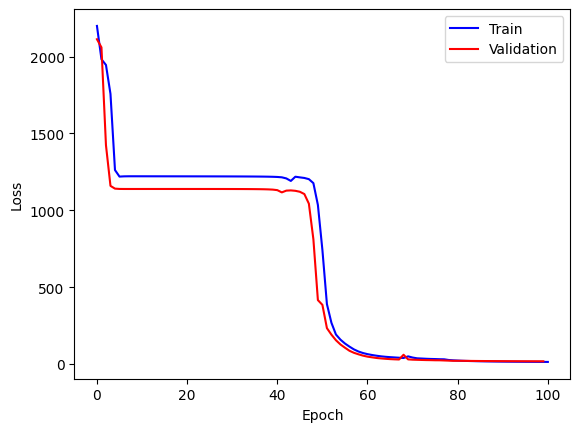

In [218]:
plot_hist(train_history, val_history)

In [223]:
y_pred = rmlp_model.predict(X_test)

print("MAE:", mae(y_test, y_pred))
_mse = mse(y_test, y_pred)
print("MSE:", _mse)
print("RMSE:", np.sqrt(_mse))
print("R^2:", r_squared(y_test, y_pred))

MAE: 3.5338573590464124
MSE: 19.027462544015435
RMSE: 4.362047975895662
R^2: 0.980877729214624


## LSTM

In [66]:
# Hyperparams

LEARNING_RATE = 1e-4
MOMENTUM_BETTA = 0.3

In [70]:
# Create model with all hidden layers
lstm_model = Model([
    LSTMLayer(14, 32),
    LSTMLayer(32, 64, return_sequences=False),
    Dense(64, 32, activation='linear'),
    Dense(32, 1, activation='linear'),
])

lstm_model.summary()

Model summary
+-----------+------------+-------------+------------+------------+
| Layer     | Input size | Output size | Num params | Activation | 
+-----------+------------+-------------+------------+------------+
| LSTMLayer | 14         | 32          | 6016       | tanh       | 
| LSTMLayer | 32         | 64          | 24832      | tanh       | 
| Dense     | 64         | 32          | 2080       | linear     | 
| Dense     | 32         | 1           | 33         | linear     | 
+-----------+------------+-------------+------------+------------+


In [71]:
# Set loss and optimizer
lstm_model.compile(
    loss='mse',
    optimizer=AdamOptimizer(learning_rate=LEARNING_RATE)
)

In [72]:
train_history, val_history = lstm_model.fit(
    X_train, y_train, 
    X_val, y_val,
    epochs=100,
    batch_size=64
)

Epoch 1/100, Epoch Loss: 2032.9600, Val. Loss: 2187.3973
Epoch 2/100, Epoch Loss: 2004.9947, Val. Loss: 2075.3875
Epoch 3/100, Epoch Loss: 1886.7200, Val. Loss: 1960.2974
Epoch 4/100, Epoch Loss: 1786.1537, Val. Loss: 1842.0363
Epoch 5/100, Epoch Loss: 1690.2304, Val. Loss: 1723.5763
Epoch 6/100, Epoch Loss: 1595.9282, Val. Loss: 1617.1594
Epoch 7/100, Epoch Loss: 1510.7136, Val. Loss: 1517.4073
Epoch 8/100, Epoch Loss: 1436.2108, Val. Loss: 1435.5568
Epoch 9/100, Epoch Loss: 1376.5906, Val. Loss: 1359.9549
Epoch 10/100, Epoch Loss: 1321.3613, Val. Loss: 1281.3160
Epoch 11/100, Epoch Loss: 1269.4231, Val. Loss: 1215.0478
Epoch 12/100, Epoch Loss: 1226.1041, Val. Loss: 1159.4699
Epoch 13/100, Epoch Loss: 1186.3216, Val. Loss: 1103.7540
Epoch 14/100, Epoch Loss: 1146.1594, Val. Loss: 1050.4577
Epoch 15/100, Epoch Loss: 1104.6770, Val. Loss: 998.1830
Epoch 16/100, Epoch Loss: 1060.3457, Val. Loss: 944.5503
Epoch 17/100, Epoch Loss: 1012.0968, Val. Loss: 889.3601
Epoch 18/100, Epoch Loss: 

KeyboardInterrupt: 

In [77]:
lstm_model.optimizer.lr = LEARNING_RATE * 2

In [78]:
train_history, val_history = lstm_model.fit(
    X_train, y_train, 
    X_val, y_val,
    epochs=30,
    batch_size=64
)

Epoch 1/30, Epoch Loss: 41.3746, Val. Loss: 52.4009
Epoch 2/30, Epoch Loss: 40.1135, Val. Loss: 50.9747
Epoch 3/30, Epoch Loss: 38.8404, Val. Loss: 49.4759
Epoch 4/30, Epoch Loss: 37.5919, Val. Loss: 47.9621
Epoch 5/30, Epoch Loss: 36.3745, Val. Loss: 46.4595
Epoch 6/30, Epoch Loss: 35.1981, Val. Loss: 44.9893
Epoch 7/30, Epoch Loss: 34.0668, Val. Loss: 43.5653
Epoch 8/30, Epoch Loss: 32.9820, Val. Loss: 42.1961
Epoch 9/30, Epoch Loss: 31.9437, Val. Loss: 40.8858
Epoch 10/30, Epoch Loss: 30.9509, Val. Loss: 39.6354
Epoch 11/30, Epoch Loss: 30.0026, Val. Loss: 38.4437
Epoch 12/30, Epoch Loss: 29.0979, Val. Loss: 37.3077
Epoch 13/30, Epoch Loss: 28.2358, Val. Loss: 36.2236
Epoch 14/30, Epoch Loss: 27.4157, Val. Loss: 35.1865
Epoch 15/30, Epoch Loss: 26.6368, Val. Loss: 34.1918
Epoch 16/30, Epoch Loss: 25.8987, Val. Loss: 33.2353
Epoch 17/30, Epoch Loss: 25.2004, Val. Loss: 32.3139
Epoch 18/30, Epoch Loss: 24.5412, Val. Loss: 31.4253
Epoch 19/30, Epoch Loss: 23.9193, Val. Loss: 30.5688
Ep

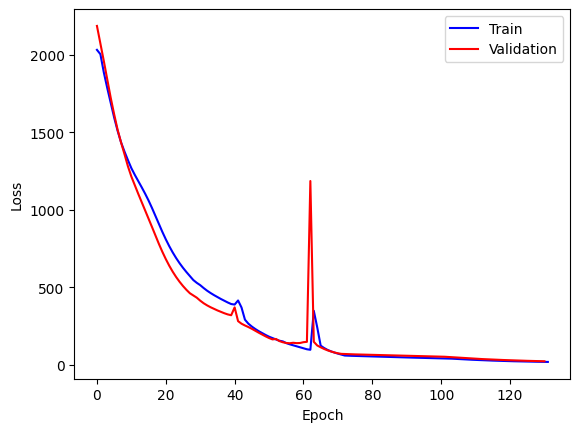

In [79]:
train_history, val_history = lstm_model.loss.history, lstm_model.loss.val_history
plot_hist(train_history, val_history)

In [81]:
batch_size = 64
y_preds = []
for batch_i in range(X_test.shape[0] // batch_size + 1):
    y_preds.append(
        lstm_model.predict(X_test[batch_i*batch_size:(batch_i + 1)*batch_size])
    )

y_pred = np.concatenate(y_preds, axis=0)
y_pred.shape

(2557, 1)

In [82]:
print("MAE:", mae(y_test, y_pred))
_mse = mse(y_test, y_pred)
print("MSE:", _mse)
print("RMSE:", np.sqrt(_mse))
print("R^2:", r_squared(y_test, y_pred))

MAE: 2.8979799179780175
MSE: 18.375856334329413
RMSE: 4.286706933571435
R^2: 0.9815325821861238


## GRU

In [140]:
# Hyperparams

LEARNING_RATE = 1e-4

In [141]:
# Create model with all hidden layers
gru_model = Model([
    GRULayer(14, 64, return_sequences=False),
    Dense(64, 32, activation='linear'),
    Dense(32, 1, activation='linear'),
])

gru_model.summary()

Model summary
+----------+------------+-------------+------------+------------+
| Layer    | Input size | Output size | Num params | Activation | 
+----------+------------+-------------+------------+------------+
| GRULayer | 14         | 64          | 15168      | tanh       | 
| Dense    | 64         | 32          | 2080       | linear     | 
| Dense    | 32         | 1           | 33         | linear     | 
+----------+------------+-------------+------------+------------+


In [142]:
# Set loss and optimizer
gru_model.compile(
    loss='mse',
    optimizer=AdamOptimizer(learning_rate=LEARNING_RATE)
)

In [143]:
train_history, val_history = gru_model.fit(
    X_train, y_train, 
    X_val, y_val,
    epochs=100,
    batch_size=32
)

Epoch 1/100, Epoch Loss: 2011.2363, Val. Loss: 2095.4099
Epoch 2/100, Epoch Loss: 1765.3099, Val. Loss: 1753.5756
Epoch 3/100, Epoch Loss: 1551.2536, Val. Loss: 1540.2439
Epoch 4/100, Epoch Loss: 1406.6725, Val. Loss: 1389.8290
Epoch 5/100, Epoch Loss: 1315.5349, Val. Loss: 1292.5585
Epoch 6/100, Epoch Loss: 1264.0907, Val. Loss: 1233.7887
Epoch 7/100, Epoch Loss: 1237.5599, Val. Loss: 1199.5080
Epoch 8/100, Epoch Loss: 1224.7133, Val. Loss: 1179.6150
Epoch 9/100, Epoch Loss: 1218.7043, Val. Loss: 1167.8695
Epoch 10/100, Epoch Loss: 1215.8770, Val. Loss: 1160.6803
Epoch 11/100, Epoch Loss: 1214.3850, Val. Loss: 1155.9446
Epoch 12/100, Epoch Loss: 1213.1179, Val. Loss: 1151.8440
Epoch 13/100, Epoch Loss: 1209.3270, Val. Loss: 1136.5331
Epoch 14/100, Epoch Loss: 1162.5751, Val. Loss: 1023.0134
Epoch 15/100, Epoch Loss: 1068.3657, Val. Loss: 958.1652
Epoch 16/100, Epoch Loss: 993.5247, Val. Loss: 892.2155
Epoch 17/100, Epoch Loss: 910.8137, Val. Loss: 820.6389
Epoch 18/100, Epoch Loss: 82

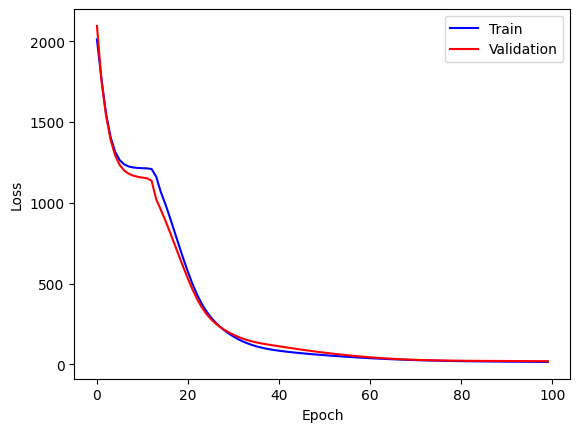

In [145]:
train_history, val_history = gru_model.loss.history, gru_model.loss.val_history
plot_hist(train_history, val_history)

In [146]:
batch_size = 64
y_preds = []
for batch_i in range(X_test.shape[0] // batch_size + 1):
    y_preds.append(
        gru_model.predict(X_test[batch_i*batch_size:(batch_i + 1)*batch_size])
    )

y_pred = np.concatenate(y_preds, axis=0)
y_pred.shape

(2557, 1)

In [147]:
print("MAE:", mae(y_test, y_pred))
_mse = mse(y_test, y_pred)
print("MSE:", _mse)
print("RMSE:", np.sqrt(_mse))
print("R^2:", r_squared(y_test, y_pred))

MAE: 2.496956827746776
MSE: 12.451164979912674
RMSE: 3.528620832550966
R^2: 0.987486794532455
